# Coursework 1 - Supervised learning

**Replace CID in the file name with your CID**

# Outline


- [Task 1](#task-1): Regression <a name="index-task-1"></a>
  - [(1.1)](#task-11) Random Forest <a name="index-task-11"></a>
    - [(1.1.1)](#task-111) <a name="index-task-111"></a>
    - [(1.1.2)](#task-112) <a name="index-task-112"></a>
    - [(1.1.3)](#task-113) <a name="index-task-113"></a>
  - [(1.2)](#task-12) Multi-layer Perceptron <a name="index-task-12"></a>
    - [(1.2.1)](#task-121) <a name="index-task-121"></a>
    - [(1.2.2)](#task-122) <a name="index-task-122"></a>
    - [(1.2.3)](#task-123) <a name="index-task-123"></a>
- [Task 2](#task-2): Classification <a name="index-task-2"></a>
  - [(2.1)](#task-21) k-Nearest Neighbours <a name="index-task-21"></a>
    - [(2.1.1)](#task-211)  <a name="index-task-211"></a>
    - [(2.1.2)](#task-212) <a name="index-task-212"></a>
    - [(2.1.3)](#task-213) <a name="index-task-213"></a>
  - [(2.2)](#task-22) Logistic regression vs kernel logistic regression <a name="index-task-22"></a>
    - [(2.2.1)](#task-221) <a name="index-task-221"></a>
    - [(2.2.2)](#task-222) <a name="index-task-222"></a>
    - [(2.2.3)](#task-223) <a name="index-task-223"></a>



---



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns

# Initial global configuration for matplotlib
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

We define a function to standardise the train and test data.

In [2]:
def standardise(X, X_train_=None):
    """
    Standardise features.
    Args:
        X (np.array): Feature matrix.
        X_train_ (np.array): An optional feature matrix to compute the statistics
            from before applying it to X. If None, just use X to compute the statistics.
    Returns:
        X_std (np.array): Standardised feature matrix
    """
    
    if X_train_ is None:
        X_train_ = X

    mu = np.mean(X_train_, axis=0)
    sigma = np.std(X_train_, axis=0)
    X_std = (X - mu) / sigma
    return X_std

<a name="task-1"></a>

# (1) Task 1: Regression [(index)](#index-task-1)

In [3]:
data_train_T1 = pd.read_csv('nanoelectrodes_capacitance_samples.csv')
data_test_T1 = pd.read_csv('nanoelectrodes_capacitance_test.csv')

data_train_T1.head()
#sns.pairplot(data_train_T1)

,Surface_Area ($m^2/g$),Defect_Ratio,Doped_Nitrogen_Percentage,Doped_Oxygen_Percentage,Doped_Sulfur_Percentage,Current_Density ($A/g$),Capacitance ($\mu F / cm^2$),Electrolyte_Concentration $[M]$,H9_Factor ($mL/g$),T5_Factor ($mL/g$),Doped_Zinc_Percentage,Doped_Flourine_Percentage,Doped_Carbon_Percentage
0,96.78,1.30,0.933333,19.690000,0.843333,6.0,173.0,6.0,11.188890,33.753753,80.542095,46.933213,50.199105
1,531.90,1.28,7.700000,13.700000,8.300000,5.0,298.5,6.0,54.206536,25.721984,36.506123,44.773787,19.238604
2,438.70,1.27,5.030000,4.760000,3.710000,2.0,404.0,2.0,46.425494,11.422661,45.927300,59.097544,67.537988
3,149.32,1.02,1.240000,15.450000,3.030000,0.3,299.7,6.0,16.322920,9.179250,69.495872,35.124313,62.494312
4,1484.00,0.84,5.740000,6.993333,0.386667,5.0,250.0,1.0,152.864772,29.174519,61.365160,50.942724,77.980072


We define (X_train, y_train) and (X_test, y_test) to learn and evaluate our model respectively, from data_train and data_test:

In [185]:
# We seperate the training features into X_train (by extracting all columns except 'Capacitance')
# and y_train which corresponds to the column 'Capacitance' (7th column): our targets.
X_train = data_train_T1.drop(data_train_T1.columns[6], axis=1)
y_train = data_train_T1[data_train_T1.columns[6]] #We keep the column 'Capacitance' of the data as our targets

# Similarly for the test set
X_test = data_test_T1.drop(data_test_T1.columns[6], axis=1)
y_test = data_test_T1[data_test_T1.columns[6]] #We keep the column 'Capacitance' of the data as our targets

<a name="task-11"></a>

## (1.1) Random Forest [(index)](#index-task-11)

In [132]:
# We define a dictionnary indicating whether the column index maps is a categorial feature or not (numerical);
# in our case all features are numerical
columns_dict = {index: False for index in range(X_train.shape[1])}

<a name="task-111"></a>

### (1.1.1) [(index)](#index-task-111)

We will build up our decision tree algorithm in the pythonic way by calling functions we define first in functions we define later.

We implement the loss function defined in the lecture notes *Chapter 6. p.57* in the case of a regression task.

In [6]:
def loss(y1, y2):
    mean_R1 = np.mean(y1)
    mean_R2 = np.mean(y2)
    return (np.sum((y1 - mean_R1)**2) + np.sum((y2 - mean_R2)**2))

Next, we define a function to split the data samples based on a feature index (column) and a value (different case if the feature is categorical or numerical).

In [7]:
def split_samples(X, y, column, value, categorical):
    """
    Return the split of data whose column-th feature:
      1. equals value, in case 'column' is categorical, or
      2. less than value, in case 'column' is not categorical (i.e. numerical)
    Args:
        X (np.ndarray): training features, of shape (N, p).
        y (np.ndarray): vector of training Capacitances, of shape (N,).
        column (index): the column of the feature for splitting.
        value (float): splitting threshold  the samples.
        categorical (bool): boolean value indicating whether column is a categorical variable or numerical.
    Returns:
        tuple(np.array, np.array): tuple of subsets of X splitted based on column-th value.
        tuple(np.array, np.array): tuple of subsets of y splitted based on column-th value.
    """
    
    if categorical:
        left_mask = (X[:,column] == value)
    else:
        left_mask = (X[:,column] < value)
    
    # Using the binary masks `left_mask`, we split X and y.
    X_l, y_l = X[left_mask,:], y[left_mask]
    X_r, y_r = X[~left_mask,:], y[~left_mask]
    
    return (X_l, y_l), (X_r, y_r)

For a given feature index, we need to estimate the best value $s$ to use as threshold (for numerical variables) or predicate (for categorical variables); this value $s$ must minimize the loss function.

In [8]:
def threshold_split(X, y, column, categorical):
    """
    Calculate the loss based on 'column' with the split 's' that minimizes the loss.
    Args:
        X (np.ndarray): Training features, of shape (N, p).
        y (np.ndarray): Vector of training Capacitances, of shape (N,).
        column (index): The column of the feature for calculating.
        categorical (bool): boolean value indicating whether column is a categorical variable or numerical.
    Return:
        loss_val (float): Resulted loss.
        threshold (float): The corresponding value 's' used in splitting.
    """
    
    unique_vals = np.unique(X[:, column])
    
    assert len(unique_vals) > 1, f"There must be more than one distinct feature value. Given: {unique_vals}."
    
    loss_val, threshold = np.inf, None
    
    for value in unique_vals:
        (X_l, y_l), (X_r, y_r) = split_samples(X, y, column, value, categorical)
        
        # If one of the two sides is empty, skip this split.
        if len(y_l) == 0 or len(y_r) == 0:
            continue
        
        current_loss = loss(y_l, y_r)
        
        if current_loss < loss_val:
            loss_val, threshold = current_loss, value
    
    return loss_val, threshold

It's now time to choose the best feature to split by calling the function 'threshold_split()' for each feature.

In [9]:
def feature_split(X, y, columns_dict):
    """
    Choose the best feature to split according to criterion.
    Args:
        X (np.ndarray): Training features, of shape (N, p).
        y (np.ndarray): Vector of training Capacitances, of shape (N,).
        columns_dict: Dictionary mapping column indices to whether the column is categorical or numerical variable.
    Returns:
        split_column (index): The best feature index.
        split_val (float): Value 's' used in splitting.
        If the feature index is None, then no valid split for the current node.
    """
    
    # Initialize 'split_column' to None, so if None returned this means there is no valid split at the current node.
    min_loss_val = np.inf
    split_column = None
    split_val = np.nan
    
    for column, categorical in columns_dict.items():
        # Skip column if samples are not seperable by that column.
        if len(np.unique(X[:,column])) < 2:
            continue
        
        # Search for the best splitting value 's' for the given column.
        current_loss_val, threshold = threshold_split(X, y, column, categorical)
        
        if current_loss_val < min_loss_val:
            min_loss_val = current_loss_val
            split_column = column
            split_val = threshold
    
    return split_column, split_val

Finally, we can recursively build the decision tree by using `feature_split()` to find the best $(j,s)$ to split the 'X', and `split_samples()` to get sub-trees.

In [10]:
def build_tree(X, y, columns_dict, feature_names, depth, max_depth=10, min_samples_leaf=10):
    """
    Build the decision tree according to the data.
    Args:
        X (np.ndarray): Training features, of shape (N, p).
        y (np.ndarray): Vector of training Capacitances, of shape (N,).
        columns_dict: Dictionary mapping column indices to whether the column is categorical or numerical variable.
        feature_names (list): Record the name of features in X in the original dataset.
        depth (int): Current depth for this node.
        max_depth (int).
        min_samples_leaf (int).
    Return:
        (dict): a dict denoting the decision tree (binary-tree). Each node has seven attributes:
          1. 'feature_name': The column name of the split.
          2. 'feature_index': The column index of the split. 
          3. 'value': The value used for the split.
          4. 'categorical': indicator for categorical/numerical variables.
          5. 'region_mean': mean of the Capacitances in region.
          6. 'left': The left sub-tree with the same structure.
          7. 'right' The right sub-tree with the same structure.
    """
    
    # Include a clause for the cases where (i) all Capacitances are the same, (ii) depth exceed (iii) X is too small
    if len(np.unique(y))==1 or depth>=max_depth or len(X)<=min_samples_leaf:
        return {'region_mean': np.mean(y)}
    
    split_index, split_val = feature_split(X, y, columns_dict)
    
    # If no valid split at this node, compute mean of the Capacitances in current region.
    if split_index is None:
        return {'region_mean': np.mean(y)}
    
    categorical = columns_dict[split_index]
    
    # Split samples (X, y) given column, split-value, and categorical flag.
    (X_l, y_l), (X_r, y_r) = split_samples(X, y, split_index, split_val, categorical)
    return {
        'feature_name': feature_names[split_index],
        'feature_index': split_index,
        'threshold': split_val,
        'categorical': categorical,
        'region_mean': None,
        'left': build_tree(X_l, y_l, columns_dict, feature_names, depth + 1, max_depth, min_samples_leaf),
        'right': build_tree(X_r, y_r, columns_dict, feature_names, depth + 1, max_depth, min_samples_leaf)
    }

We define a wrapper function that we call `train()` to call this `build_tree()` function with the appropriate arguments.

In [11]:
def train(X, y, columns_dict):
    """
    Train the decision tree.
    Args:
        X (pd.Dataframe): Training features, of shape (N, p). Each X[i] is a training sample.
        y (pd.Series): Vector of training values of Capacitance, of shape (N,). y[i] is the Capacitance for X[i].
        columns_dict: Dictionary mapping column indices to whether the column is categorical or numerical variable.
    Return:
        Decision tree.
    """
    
    feature_names = X.columns.tolist()
    return build_tree(X.to_numpy(), y.to_numpy(), columns_dict, feature_names, depth=1)

In [12]:
# Fit the decision tree with training data
tree = train(X_train, y_train, columns_dict)

Now, we want to use this fitted decision tree to make predictions for our test set 'X_test'. To do so, we first define a function `algorithm_tree()` that takes each single data point 'x' as an argument. We will write a wrapper function `predict()` that calls this `algorithm_tree()` function. In the following implementation, we will recursively traverse a given decision tree basen on the current feature vector that we have.

In [13]:
def algorithm_tree(tree, x):
    """
    Estimate the Capacitance of a single sample with the fitted decision tree.
    Args:
        tree: Decision tree.
        x (pd.Dataframe): A single sample features, of shape (D,).
    Return:
        (float): Estimated Capacitance of x.
    """
    
    if tree['region_mean'] is not None:
        return tree['region_mean']
    
    elif tree['categorical']:
        if x[tree['feature_index']] == tree['threshold']:
            return algorithm_tree(tree['left'], x)
        else:
            return algorithm_tree(tree['right'], x)
        
    else:
        if x[tree['feature_index']] < tree['threshold']:
            return algorithm_tree(tree['left'], x)
        else:
            return algorithm_tree(tree['right'], x)

In [179]:
def predict(tree, X):
    """
    Estimate the Capacitances for X with the fitted decision tree.
    Args:
        tree: Decision tree.
        X (pd.Dataframe): Testing sample features, of shape (N, p).
    Returns:
        (np.array): Estimated Capacitances of X, of shape (N,).
    """
    
    if len(X.shape) == 1:
        return algorithm_tree(tree, X)
    else:
        return np.array([algorithm_tree(tree, x) for x in X])

To evaluate how well the tree can generalise to unseen data in 'X_test', we define a function that computes the MSE and $R^2$ scores.

In [15]:
def tree_score(tree, X_test, y_test):
    y_pred = predict(tree, X_test)
    
    #MSE
    mse = np.mean((y_pred - y_test)**2)
    
    #R2 score
    numerator = np.sum((y_test - y_pred)**2)
    y_avg = np.mean(y_test)
    denominator = np.sum((y_test - y_avg)**2)
    r2_score = 1 - numerator/denominator
    
    return mse, r2_score

In [16]:
print('DT Train score (MSE, R^2):', tree_score(tree, X_train.to_numpy(), y_train.to_numpy()))
print('DT Test score (MSE, R^2):', tree_score(tree, X_test.to_numpy(), y_test.to_numpy()))

DT Train score (MSE, R^2): (1654.4051506951573, 0.7503640060081044)
DT Test score (MSE, R^2): (3369.5671069811706, 0.4896216113769649)


**Analysis:** The decision tree model performs pretty well on the train set with a MSE of $1654$ and a $R^2$ score of $0.75$. However, it does not seem to generalise well to unseen data with a MSE score $3370$ and a not optimal $R^2$ score of $0.49$.

<a name="task-112"></a>

### (1.1.2) [(index)](#index-task-112)

We now need to sample 'n_features' from the columns at each split, before we scan for the optimal splitting column. It is required to make adapted versions of `feature_split()` and `build_tree()`.

In [17]:
def feature_split_rf(n_features, X, y, columns_dict):
    """
    Choose the best feature among n_features to split according to criterion.
    Args:
        n_features (int): Number of features to sample from the columns at each split.
        X (np.ndarray): Training features, of shape (N, p).
        y (np.ndarray): Vector of training Capacitances, of shape (N,).
        columns_dict: Dictionary mapping column indices to whether the column is categorical or numerical variable.
    Returns:
        split_column (index): The best feature index.
        split_val (float): Value 's' used in splitting.
        If the feature index is None, then no valid split for the current node.
    """
    
    # Sampling step.
    columns = np.random.choice(list(columns_dict.keys()), n_features, replace=False)
    columns_dict = {c: columns_dict[c] for c in columns}
    
    # Initialize 'split_column' to None, so if None returned this means there is no valid split at the current node.
    min_loss_val = np.inf
    split_column = None
    split_val = np.nan
    
    for column, categorical in columns_dict.items():
        # Skip column if samples are not seperable by that column.
        if len(np.unique(X[:,column])) < 2:
            continue
        
        # Search for the best splitting value for the given column.
        current_loss_val, threshold = threshold_split(X, y, column, categorical)
        
        if current_loss_val < min_loss_val:
            min_loss_val = current_loss_val
            split_column = column
            split_val = threshold
    
    return split_column, split_val

In [18]:
def build_tree_rf(n_features, X, y, columns_dict, feature_names, depth, max_depth=10, min_samples_leaf=10, oob_indices=None):
    """
    Build the random forest according to the data.
    Args:
        n_features (int): Number of features to sample from the columns at each split.
        X (np.ndarray): Training features, of shape (N, p).
        y (np.ndarray): Vector of training Capacitances, of shape (N,).
        columns_dict: Dictionary mapping column indices to whether the column is categorical or numerical variable.
        feature_names (list): Record the name of features in X in the original dataset.
        depth (int): Current depth for this node.
        max_depth (int).
        min_samples_leaf (int).
    Return:
        (dict): a dict denoting the decision tree (binary-tree). Each node has seven attributes:
          1. 'feature_name': The column name of the split.
          2. 'feature_index': The column index of the split.
          3. 'value': The value used for the split.
          4. 'categorical': indicator for categorical/numerical variables.
          5. 'oob_indices': out-of-bag indices sample.
          6. 'region_mean': mean of the Capacitances in region.
          7. 'left': The left sub-tree with the same structure.
          8. 'right' The right sub-tree with the same structure.
    """
    
    # Include a clause for the cases where (i) all Capacitances are the same, (ii) depth exceed (iii) X is too small
    if len(np.unique(y))==1 or depth>=max_depth or len(X)<=min_samples_leaf:
        return {'region_mean': np.mean(y)}
    
    split_index, split_val = feature_split_rf(n_features, X, y, columns_dict)
    
    # If no valid split at this node, compute mean of the Capacitances in current region.
    if split_index is None:
        return {'region_mean': np.mean(y)}
    
    categorical = columns_dict[split_index]
    
    # Split samples (X, y) given column, split-value, and categorical flag.
    (X_l, y_l), (X_r, y_r) = split_samples(X, y, split_index, split_val, categorical)
    return {
        'feature_name': feature_names[split_index],
        'feature_index': split_index,
        'threshold': split_val,
        'categorical': categorical,
        'oob_indices': oob_indices,
        'region_mean': None,
        'left': build_tree_rf(n_features, X_l, y_l, columns_dict, feature_names, depth + 1, max_depth, min_samples_leaf),
        'right': build_tree_rf(n_features, X_r, y_r, columns_dict, feature_names, depth + 1, max_depth, min_samples_leaf)
    }

We write the training function `train_rf()` to construct multiple decision trees, each operating on a subset of samples (with replacement).

In [19]:
def train_rf(B, n_features, X, y, columns_dict, max_depth=10, min_samples_leaf=10):
    """
    Train the random forest.
    Args:
        B (int): Number of trees.
        n_features (int): Number of features to sample from the columns at each split.
        X (pd.Dataframe): Training features, of shape (N, p). Each X[i] is a training sample.
        y (pd.Series): Vector of training values of Capacitance, of shape (N,). y[i] is the Capacitance for X[i].
        columns_dict: Dictionary mapping column indices to whether the column is categorical or numerical variable.
        max_depth (int).
        min_samples_leaf (int).
    Return:
        Random forest.
    """
    
    feature_names = X.columns.tolist()
    X = X.to_numpy()
    y = y.to_numpy()
    N = X.shape[0]
    training_indices = np.arange(N)
    trees = []
    
    for _ in range(B):
        # Sample the training_indices (with replacement)
        sample = np.random.choice(training_indices, N, replace=True)
        oob_indices = set(training_indices) - set(sample) # Out-of-bag indices sample
        X_sample = X[sample, :]
        y_sample = y[sample]
        tree = build_tree_rf(n_features, X_sample, y_sample, columns_dict, feature_names, depth=1, max_depth=max_depth, min_samples_leaf=min_samples_leaf, oob_indices=oob_indices)
        trees.append(tree)

    return trees

Let's define the prediction function `predict_rf()` which aggregates the Capacitance from all decision trees and returns the mean of all these Capacitances.

In [178]:
def predict_rf(rf, X):
    """
    Estimate the Capacitances for X with the fitted random forest.
    Args:
        rf: Random forest.
        X (pd.Dataframe): Testing sample features, of shape (N, p).
    Returns:
        (np.array): Estimated Capacitances of X, of shape (N,).
    """
    
    if len(X.shape) == 1:
        return np.mean([predict(tree, X) for tree in rf])
    else:
        return np.array([np.mean([predict(tree, x) for tree in rf]) for x in X])

Similarly, to evaluate how well the random forest can generalise to unseen data in 'X_test', we define a function that computes the MSE and $R^2$ scores.

In [21]:
def rf_score(rf, X_test, y_test):
    y_pred = predict_rf(rf, X_test)
    
    #MSE
    mse = np.mean((y_pred - y_test)**2)
    
    #R2 score
    numerator = np.sum((y_test - y_pred)**2)
    y_avg = np.mean(y_test)
    denominator = np.sum((y_test - y_avg)**2)
    r2_score = 1 - numerator/denominator
    
    return mse, r2_score

We carry out a 5-fold cross-validation, using the MSE of the Random Forest as performance metric, to find the best $B$ to fit our random forest.

In [22]:
def B_cross_validation(n_features, X, y, columns_dict, folds, B, max_depth=10, min_samples_leaf=10):
    scores = []
    
    for i in range(len(folds)):
        val_indexes = folds[i]
        train_indexes = list(set(range(y.shape[0])) - set(val_indexes))
        
        X_train_i = X.iloc[train_indexes, :]
        y_train_i = y[train_indexes]
        
        X_val_i = X.iloc[val_indexes, :]
        y_val_i = y[val_indexes]
        
        rf_i = train_rf(B, n_features, X_train_i, y_train_i, columns_dict, max_depth=max_depth, min_samples_leaf=min_samples_leaf)

        score_i = rf_score(rf_i, X_val_i.to_numpy(), y_val_i.to_numpy())[0] # Keep only MSE score
        scores.append(score_i)
    
    # Return the average MSE score
    return sum(scores) / len(scores)

Let's scan a range of B in [1, 41] with 'early stopping' and select the one with the best cross-validation accuracy.

Since the algorithm takes considerable time to run, we set a _tol_ of 150. This _tol_ is not overly excessive as, towards the end, the MSE tends to oscillate between 3000 and 3500 while each iteration takes more and more time. Nevertheless, we set a _max_patience_ of 5 which gives more flexibility.

In [34]:
def choose_best_B(n_features, X, y, columns_dict, folds, B_range, max_depth=10, min_samples_leaf=10, tol=150, max_patience=5):
    B_scores = []
    
    epochs_bar_B = tqdm(enumerate(B_range), total=len(B_range))
    
    # Implement 'early stopping' as this method can take a lot of time
    previous_score = np.inf
    patience = 0
    
    for i, B in epochs_bar_B:
        B_scores.append(B_cross_validation(n_features, X, y, columns_dict, folds, B, max_depth=max_depth, min_samples_leaf=min_samples_leaf))
        epochs_bar_B.set_description(f'B = {B}, MSE: {B_scores[i]:.2f}')
        
        # Early stopping
        if (np.abs(previous_score - B_scores[-1]) < tol):
            patience += 1
        else:
            patience = 0
            
        if (patience >= max_patience):
            print(f'Early stopping at B={B}')
            break
        
        previous_score = B_scores[-1]
            
    
    B_scores = np.array(B_scores)
    best_B_index = np.argmin(B_scores)
    return B_scores, B_range[best_B_index]

  0%|          | 0/40 [00:00<?, ?it/s]

Early stopping at B=23


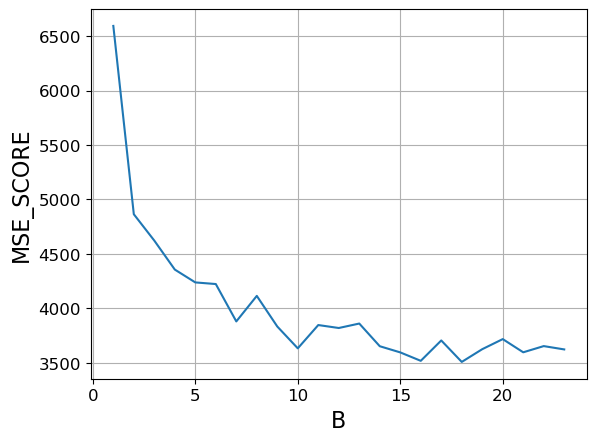

Best B is: 18


In [35]:
n_features = int(X_train.shape[1]/3)
folds_indexes = np.array_split(np.arange(len(y_train)), 5)

B_scores, best_B = choose_best_B(n_features, X_train, y_train, columns_dict, folds_indexes, np.arange(1,41), max_depth=10, min_samples_leaf=10)

plt.plot(np.arange(1, len(B_scores)+1), B_scores)
plt.xlabel('B')
plt.ylabel('MSE_SCORE')
plt.grid()
plt.show()

print('Best B is:', best_B)

Finally, let's fit our random forest (+ random forest without feature bagging) and evaluate its performance with the best $B$ on both the train set and test set.

In [39]:
rf_best_B = train_rf(best_B, n_features, X_train, y_train, columns_dict, max_depth=10, min_samples_leaf=10)

# We keep the same best_B for RF without feature bagging (as told on edstem)
rf_best_B_no_feature_bagging = train_rf(best_B, X_train.shape[1], X_train, y_train, columns_dict, max_depth=10, min_samples_leaf=10)

In [40]:
# We keep the same best_B for RF without feature bagging (as told on edstem)

rf_score_train = rf_score(rf_best_B, X_train.to_numpy(), y_train.to_numpy())
rf_score_test = rf_score(rf_best_B, X_test.to_numpy(), y_test.to_numpy())

print('RF Train score (MSE, R^2):', rf_score_train)
print('RF Test score (MSE, R^2):', rf_score_test)

print('\nDT Train score (MSE, R^2):', tree_score(tree, X_train.to_numpy(), y_train.to_numpy()))
print('DT Test score (MSE, R^2):', tree_score(tree, X_test.to_numpy(), y_test.to_numpy()))

print('\nRF (No feature bagging) Train score (MSE, R^2):', rf_score(rf_best_B_no_feature_bagging, X_train.to_numpy(), y_train.to_numpy()))
print('RF (No feature bagging) Test score (MSE, R^2):', rf_score(rf_best_B_no_feature_bagging, X_test.to_numpy(), y_test.to_numpy()))

RF Train score (MSE, R^2): (1284.5932239053573, 0.8061655537096689)
RF Test score (MSE, R^2): (3190.8231385143285, 0.5166954329409239)

DT Train score (MSE, R^2): (1654.4051506951573, 0.7503640060081044)
DT Test score (MSE, R^2): (3369.5671069811706, 0.4896216113769649)

RF (No feature bagging) Train score (MSE, R^2): (1179.8265924955085, 0.8219739680863957)
RF (No feature bagging) Test score (MSE, R^2): (3035.750965670511, 0.5401837574596207)


**Analysis:** First of all, we observe that the Random forest is doing better than the Decision tree, which aligns with our expectations. However, the time required to train the Random forest, especially the time taken to find the best $B$ by cross-validation, might not be worth the improvement compared to the Decision tree: $-300$ for MSE and $+0.04$ for $R^2$ score on the train set and almost no improvement on the test set. 

Furthermore, we observe that the Random forest with no feature bagging fits the training set better, with lower MSE and higher $R^2$ score. Nevertheless, its performance on the test set is similar to that of the Random forest. These observations align with the concept behind feature bagging, which introduces randomness to reduce overfitting of the training set.

In the following parts, we will use $best\_B$.

<a name="task-113"></a>

### (1.1.3) [(index)](#index-task-113)

We carry out a 5-fold cross-validation, using the MSE of the random forest as performance metric, to find the best $max\_depth$ and $min\_samples\_leaf$ to fit our random forest.

In [41]:
def depth_leaf_cross_validation(B, n_features, X, y, columns_dict, folds, max_depth, min_samples_leaf):
    scores = []
    
    for i, fold in enumerate(folds):
        val_indexes = fold
        train_indexes = list(set(range(y.shape[0])) - set(val_indexes))
        
        X_train_i = X.iloc[train_indexes, :]
        y_train_i = y[train_indexes]
        
        X_val_i = X.iloc[val_indexes, :]
        y_val_i = y[val_indexes]
        
        rf_i = train_rf(B, n_features, X_train_i, y_train_i, columns_dict, max_depth, min_samples_leaf)
        
        score_i = rf_score(rf_i, X_val_i.to_numpy(), y_val_i.to_numpy())[0] # Keep only MSE score
        scores.append(score_i)
    
    # Return the average MSE score
    return sum(scores) / len(scores)

Let's scan a range of $max\_depth$ and $min\_samples\_leaf$ in respectively $[1,20]$ and $[1,15]$ with early stopping and select the couple with the best cross-validation accuracy.

Since the algorithm takes considerable time to run, we set a _tol_ of $100$. Nevertheless, we set a _max_patience_ of $5$ which gives more flexibility.

In [42]:
def choose_best_depth_leafs(B, n_features, X, y, columns_dict, folds, max_depth_range, min_samples_leaf_range, tol=1e2, max_patience=5, print_progression=False):
    DL_scores = np.full((len(max_depth_range),len(min_samples_leaf_range)), np.inf)
    
    # Early stopping
    previous_score_leaf = np.inf
    patience_depth = 0
    
    for i, max_depth in enumerate(max_depth_range):
        epochs_bar_leaf = tqdm(enumerate(min_samples_leaf_range), total=len(min_samples_leaf_range))
        
        patience_leaf = 0
        for j, min_samples_leaf in epochs_bar_leaf:
            DL_scores[i,j] = depth_leaf_cross_validation(B, n_features, X, y, columns_dict, folds, max_depth, min_samples_leaf)
            epochs_bar_leaf.set_description(f'max_depth={max_depth}, min_samples_leaf={min_samples_leaf}, MSE:{DL_scores[i,j]:.2f}')
            
            # Early stopping for leaf
            if np.abs(previous_score_leaf - DL_scores[i,j]) < tol:
                patience_leaf += 1
            else:
                patience_leaf = 0

            if (patience_leaf >= max_patience):
                print(f'Early stopping over leaf at min_samples_leaf={min_samples_leaf}')
                break

            previous_score_leaf = DL_scores[i,j]
    
        # Early stopping for depth
        if i > 0:
            if np.abs(DL_scores[i-1,j] - DL_scores[i,j]) < tol:
                patience_depth += 1
            else:
                patience_depth = 0

            if (patience_depth >= max_patience):
                print(f'Early stopping over leaf at max_depth={max_depth} and min_samples_leaf={min_samples_leaf}')
                break
            
    
    best_indexes = np.argmin(np.array(DL_scores))
    best_indexes = np.unravel_index(best_indexes, DL_scores.shape)
    
    return DL_scores, max_depth_range[best_indexes[0]], min_samples_leaf_range[best_indexes[1]]

In [43]:
n_features = int(X_train.shape[1]/3)
folds_indexes = np.array_split(np.arange(len(y_train)), 5)

_, best_max_depth, best_min_samples_leaf = choose_best_depth_leafs(best_B, n_features, X_train, y_train, columns_dict, folds_indexes, np.arange(1, 21), np.arange(1, 16), print_progression=True)

print(f'best_max_depth={best_max_depth} and best_min_samples_leaf={best_min_samples_leaf}')

  0%|          | 0/15 [00:00<?, ?it/s]

Early stopping over leaf at min_samples_leaf=6


  0%|          | 0/15 [00:00<?, ?it/s]

Early stopping over leaf at min_samples_leaf=11


  0%|          | 0/15 [00:00<?, ?it/s]

Early stopping over leaf at min_samples_leaf=6


  0%|          | 0/15 [00:00<?, ?it/s]

Early stopping over leaf at min_samples_leaf=6


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Early stopping over leaf at min_samples_leaf=7


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Early stopping over leaf at min_samples_leaf=6


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Early stopping over leaf at min_samples_leaf=6


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

best_max_depth=19 and best_min_samples_leaf=3


Finally, let's evaluate the accuracy with the best $B$, $max\_depth$ and $min\_samples\_leaf$ on X_train and X_test.

In [186]:
rf_all_best = train_rf(best_B, n_features, X_train, y_train, columns_dict, max_depth=best_max_depth, min_samples_leaf=best_min_samples_leaf)

In [187]:
print('RF_all_best Train score (MSE, R^2):', rf_score(rf_all_best, X_train.to_numpy(), y_train.to_numpy()))
print('RF_all_best Test score (MSE, R^2):', rf_score(rf_all_best, X_test.to_numpy(), y_test.to_numpy()))

print('\nRF Train score (MSE, R^2):', rf_score(rf_best_B, X_train.to_numpy(), y_train.to_numpy()))
print('RF Test score (MSE, R^2):', rf_score(rf_best_B, X_test.to_numpy(), y_test.to_numpy()))

RF_all_best Train score (MSE, R^2): (375.75712279433884, 0.943301371608469)
RF_all_best Test score (MSE, R^2): (2739.7960519804733, 0.5850111750947358)

RF Train score (MSE, R^2): (1284.5932239053573, 0.8061655537096689)
RF Test score (MSE, R^2): (3190.8231385143285, 0.5166954329409239)


**ANALYSIS:** As expected, the random forest with all the best hyperparameters is performing better than the random forest with only the best $B$. Indeed, it has a way lower MSE on the train set and thus a very good $R^2$ score of $0.94$. Nevertheless, the improvement on the test set is much less impressive. 

Overall, this last Random forest with all the best hyperparameters outperform the other previous Random forest and Decision tree. However, as estimating $best\_max\_depth$ and $best\_min\_samples\_leaf$ takes a significant amount of time, the improvement of the model (compared to Random forest with best $B$) might not be worth the time taken.

Let's now estimate the importance factors of each feature, using the Out-Of-Bag samples from bagging and the MSE as performance metric. We will proceed as follows:
- First, iterate over the features of _X_train_;
- Copy _X_train_ in _X_train_shuffled and shuffle the values of the column 'feature' in _X_train_shuffled;
- Iterate over the trees of the random forest rf;
- For each tree define _X_train_oob_, _X_train_shuffled_oob_ and _y_train_oob_ from the out-of-bag indices of the tree;
- Compute the MSE of the out-of-bag samples with _mse_shuffled_oob_  and without shuffling _mse_oob_ (+= over the trees);
- After iterating over the trees, estimate the decrease in the MSE: _mse_shuffled_oob_ - _mse_oob_ and store it in a dictionary _features_importance_ as the importance of _current_feature_;
- Identify the feature with the maximum importance in _features_importance_;
- Create a dictionary which contains the importance of each feature as a percentage of the most important feature;
- Sort this last dictionary for a better visualisation when plotting;
- Plot using plt.barh.

In [188]:
def rf_feature_importance(rf, X_train, y_train):
    """
    Estimate the importance of each feature.
    Args:
        rf: Random forest.
        X_train (pd.Dataframe): Training features, of shape (N, p).
        y_train (pd.Dataframe): Vector of training Capacitances, of shape (N,).
    Returns:
        percentages_importance (dictionary): Sorted features importance.
    """
    
    features_importance = {feature: 0 for feature in X_train.columns}
    
    for feature in features_importance:
        X_train_shuffled = X_train.copy()
        
        # Let's shuffle the values of column feature
        values = X_train_shuffled.loc[:, feature].values
        np.random.shuffle(values)
        X_train_shuffled.loc[:, feature] = values
        
        # Now let's compute MSE of OOB samples before and after shuffle
        mse_oob = 0.
        mse_shuffled_oob = 0.
        for tree in rf:
            oob_indices = list(tree['oob_indices'])
       
            X_train_oob = X_train.iloc[oob_indices,:] 
            X_train_shuffled_oob = X_train_shuffled.iloc[oob_indices,:]
            y_train_oob = y_train[oob_indices]
            
            mse_oob += tree_score(tree, X_train_oob.to_numpy(), y_train_oob.to_numpy())[0]
            mse_shuffled_oob += tree_score(tree, X_train_shuffled_oob.to_numpy(), y_train_oob.to_numpy())[0]
        
        features_importance[feature] = mse_shuffled_oob - mse_oob
    
    # Identify the feature which contribute the most to the prediction of the Capacitance.
    max_importance = max(features_importance.values())
    
    # Create a dictionary which contains the importance of each feature as a percentage of the most important feature.
    percentages_importance = {feature: (importance / max_importance)*100 for feature, importance in features_importance.items()}
    # Sort the dictionary for better visualisation.
    percentages_importance = dict(sorted(percentages_importance.items(), key=lambda item: item[1], reverse=False))
    
    return percentages_importance

We carry out 6 different experiments as the method contains some randomness from _'np.random.shuffle(values)'_. 

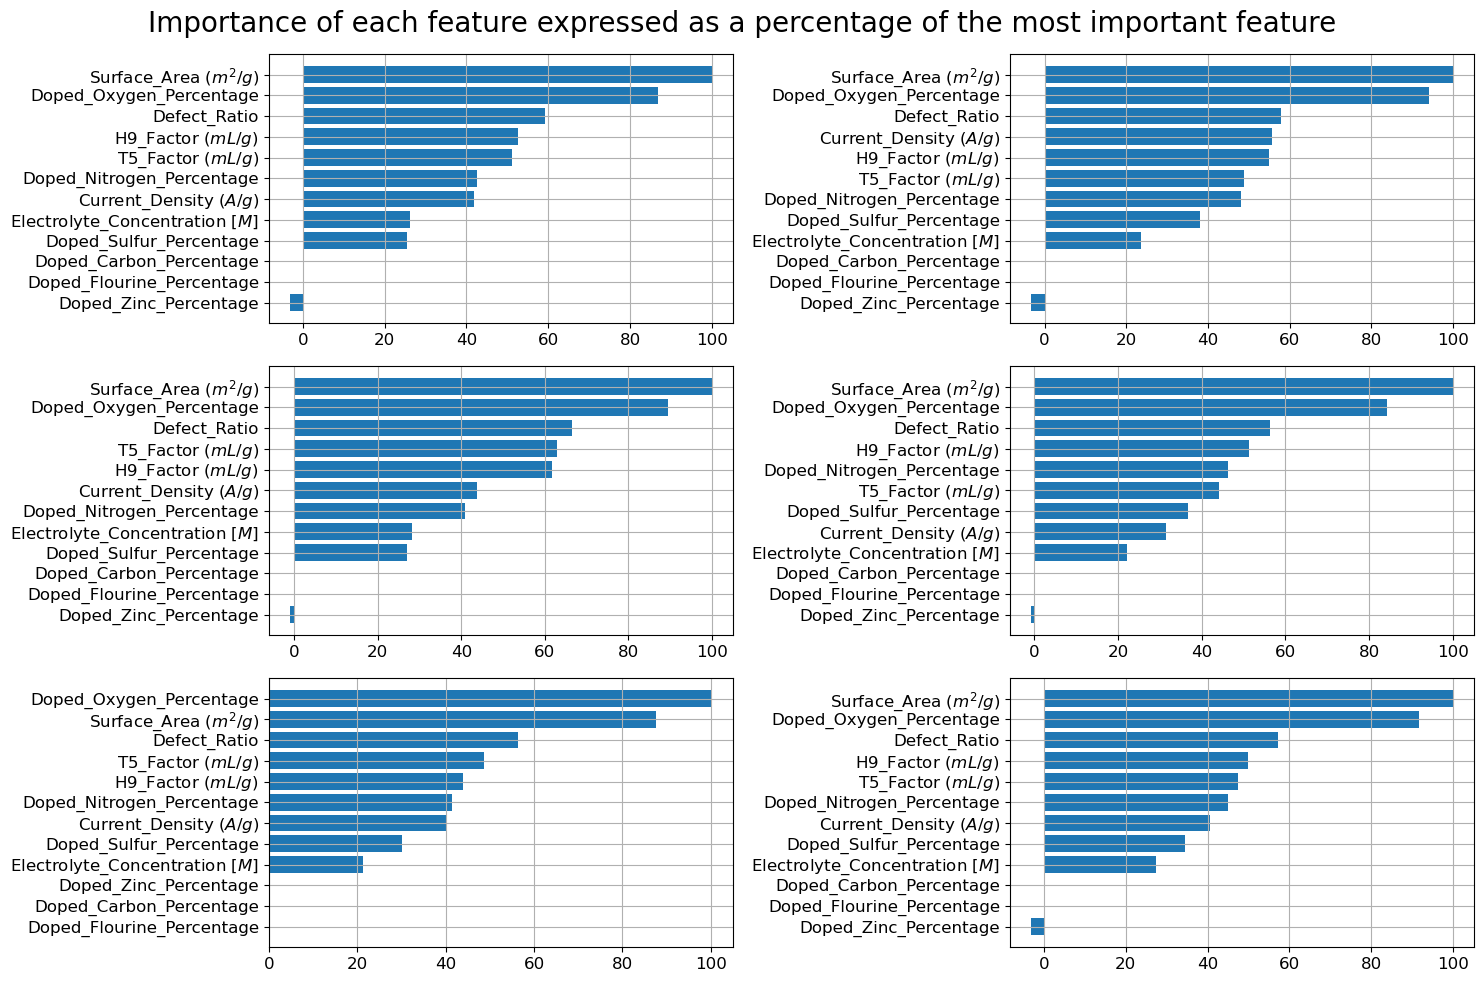

In [189]:
fig, plots = plt.subplots(3, 2, figsize=(15, 10), tight_layout=True)

for row in plots:
    for j, current_plot in enumerate(row):
        percentages_importance = rf_feature_importance(rf_all_best, X_train, y_train)
        current_plot.barh(list(percentages_importance.keys()), list(percentages_importance.values()))
        current_plot.grid()
        
plt.suptitle('Importance of each feature expressed as a percentage of the most important feature')
plt.show()

Based on these experiments, we deduce that the most significant features are (unordered): 'Surface Area', 'Defect Ratio', 'Doped Oxygen Percentage' and 'H9 Factor', with 'Surface Area' tending to be the most important feature.



---



<a name="task-12"></a>

## (1.2) Multi-layer Perceptron [(index)](#index-task-12)

Just to make sure we use the original data.

In [190]:
# We seperate the training features into X_train (by extracting all columns except 'Capacitance')
# and y_train which corresponds to the column 'Capacitance' (7th column): our targets.
X_train = data_train_T1.drop(data_train_T1.columns[6], axis=1)
y_train = data_train_T1[data_train_T1.columns[6]] #We keep the column 'Capacitance' of the data as our targets

# Similarly for the test set
X_test = data_test_T1.drop(data_test_T1.columns[6], axis=1)
y_test = data_test_T1[data_test_T1.columns[6]] #We keep the column 'Capacitance' of the data as our targets

In [191]:
# Standardise train and test data
X_test = standardise(X_test, X_train_=X_train)
X_train = standardise(X_train)

<a name="task-121"></a>

### (1.2.1) [(index)](#index-task-121)

The following function `dense()` implements the affine transformation of the dense (or fully-connected) layer, given kernel and bias parameters and the input to the layer. It returns the layer pre-activations.

In [192]:
def dense(X, W, b):
    """
    Full-connected MLP layer.
    Args:
        X (np.ndarray): (K x h_in) array of inputs, where K is the batch size and h_in if the input features dimension.
        W (np.ndarray): (h_out x h_in) array for kernel matrix parametersm, where h_out is the output dimension.
        b (np.ndarray): Length (h_out) 1-D array for bias parameters.
    Return:
        a (np.ndarray): (K x h_out) array of pre-activations.
    """
    
    a = np.vstack([W @ x + b for x in X])
    return a

The hidden layers of our model will use the following activation function:

$$\sigma_r(x)=tan^{-1}(x)ln(|x|+1)$$

We implement this activation function and its gradient, which will be required in the backpropagation of the MLP.

In [193]:
def fun_activation(a):
    """
    Activation function.
    Arg:
        a (np.ndarray): (K x h_out) array of pre-activations.
    Return:
        h (np.ndarray): (K x h_out) array of post-activations.
    """
    
    # Compute post-activations
    h = np.arctan(a) * np.log(np.abs(a) + 1)
    return h


def grad_fun_activation(a):
    """
    Gradient of the activation function.
    Arg:
        a (np.ndarray): (K x h_out) array of pre-activations.
    Return:
        grad (np.ndarray): (K x h_out) gradient array of post-activations.
    """
    
    # Compute gradient
    grad = np.log(np.abs(a) + 1) / (1 + a**2) + np.arctan(a) * np.sign(a) / (np.abs(a) + 1)
    return grad

In [194]:
# A lookup table for activation functions by their names.
activation_table = {
    "fun": fun_activation,
    # Identity function.
    "identity": lambda x: x
}

# A lookup table for gradient of activation functions by their names.
grad_activation_table = {
    "fun": grad_fun_activation,
    # Identity function gradient.
    "identity": lambda x: np.ones_like(x)
}


class MLP:
    """
    This class represents a Multi-Layer Perceptron (MLP), that we use to encapsulate two components:
        1. layers: the sequence of layers, where each layer is stored in
            a dictionary in the format {"W": np.ndarray, "b": np.ndarray},
            where "W" points to the weights array, and "b" points to
            the bias vector.
        2. rng: a pseudo random number generator (RNG) initialised to generate
            the random weights in a reproducible manner between different
            runtime sessions.
    This class is also shipped with methods that perform essential operations
    with a MLP, including:
        - add_layers: which creates a new layer with specified dimensions.
        - predict: applies the MLP forward pass to make predictions and produces
            a computational graph for the forward pass that can be used to
            compute gradients using backpropagation algorithm.
        in addition to other light functions that return simple statistics about
        the MLP.
    """
    
    def __init__(self, seed=42):
        self.layers = []
        self.rng = np.random.default_rng(seed)

    def n_parameters(self):
        """Return the total number of parameters of weights and biases."""
        return sum(l["b"].size + l["W"].size for l in self.layers)

    def n_layers(self):
        """Return current number of MLP layers."""
        return len(self.layers)

    def layer_dim(self, index):
        """Retrieve the dimensions of the MLP layer at `index`."""
        return self.layers[index]["W"].shape

    def add_layer(self, in_dim, out_dim, activation="identity"):
        """
        Add fully connected layer to MLP.
        Args:
            in_dim (int): The output dimension of the layer.
            out_dim (int): The input dimension of the layer.
            activation (str): The activation function name.
        """
        
        # Check if input-dimension matches output-dimension of previous layer
        if self.n_layers() > 0:
            last_out_dim, _ = self.layer_dim(-1)
            assert in_dim == last_out_dim, f"Input-dimension {in_dim} does not match output-dimension {last_out_dim} of previous layer."

        # The first layer, in our convention illustrated, does not apply activation on the input features X.
        if self.n_layers() == 0:
            assert activation == "identity", "Should not apply activations on the input features X, use Identity function for the first layer."


        # Store each layer as a dictionary in the list
        self.layers.append({
            "index": len(self.layers),
            # Apply Glorot initialisation for weights.
            "W": self.rng.normal(size=(out_dim, in_dim)) * np.sqrt(2. / (in_dim + out_dim)),
            # Initialise bias vector with zeros.
            "b": np.zeros(out_dim),
            # Store the activation function (as string)
            "activation": activation
        })


    def predict(self, X):
        """
        Apply the forward pass on the input X and produce prediction and the
        forward computation graph.
        Arg:
            X (np.ndarray): Feature matrix.
        Returns:
            (np.ndarray, List[Dict[str, np.ndarray]]): A tuple of the
            predictions and the computation graph as a sequence of intermediate
            values through the MLP, specifically each layer will have a corresponding
            intermediate values {"a": np.ndarray, "h": np.ndarray}, as shown in the
            attached diagram above.
        """
        
        # We assume that we work with a batch of examples (ndim==2).
        if X.ndim == 1:
            # If one example passed, add a dummy dimension for the batch.
            X = X.reshape(1, -1)

        # Store pre- and post-activations in list
        forward_pass = [{"index": 0, "a": X, "h": X}]

        # Iterate through hidden layers
        for k in range(1, len(self.layers)):
            # Compute pre-activations
            a = dense(forward_pass[k - 1]["h"], self.layers[k - 1]["W"], self.layers[k - 1]["b"])
            activation = activation_table[self.layers[k]["activation"]]
            forward_pass.append({"index": k, "a" : a, "h" : activation(a)})

        y_hat = dense(forward_pass[-1]["h"], self.layers[-1]["W"], self.layers[-1]["b"])
        # Predicted target is output of last layer
        return y_hat, forward_pass

We use the MSE loss function to evaluate the performance of our model.

In [195]:
def mse_loss(y_true, y_pred):
    """
    Compute MSE-loss.
    Args:
        y_true (np.ndarray): Ground-truth array (K, ).
        y_pred (np.ndarray): Predictions array (K, ).
    Return:
        loss (float): MSE-loss.
    """
    
    assert y_true.size == y_pred.size, "Ground-truth and predictions have different dimensions."

    # Adjustment to avoid subtraction between (K,) and (1, K) arrays.
    y_true = y_true.reshape(y_pred.shape)

    return np.mean((y_true - y_pred)**2, keepdims=True)

In [196]:
def grad_mse_loss(y_true, y_pred):
    """
    Compute gradient of MSE-loss.
    Args:
        y_true (np.ndarray): Ground-truth values (K, ).
        y_pred (np.ndarray): Prediction values (K, ).
    Return:
        grad (np.ndarray): Gradient of MSE-loss (K, ).
    """
    
    # Adjustment to avoid subtraction between (K,) and (1, K) arrays.
    y_true = y_true.reshape(y_pred.shape)

    return 2.0 * (y_pred - y_true) / y_true.size

In [197]:
def backpropagate(layers, forward_pass, delta_output):
    """
    Apply the backpropagation algorithm to the MLP layers to compute the gradients starting from
    the output layer to the input layer, and starting the chain rule from the
    partial derivative of the loss function w.r.t the predictions y_hat.
    Args:
        layers (List[Dict[str, np.ndarray]]): The MLP sequence of layers, as shown in the diagrams.
        forward_pass (List[Dict[str, np.ndarray]]): The forward pass intermediate values for
            each layer, representing a computation graph.
        delta_output (np.ndarray): the partial derivative of the loss function w.r.t the
            predictions y_hat, has the shape (K, 1), where K is the batch size.
    Return:
        (List[Dict[str, np.ndarray]]): The computed gradient using a structure symmetric the layers.
    """
    
    # Create a list that will contain the gradients of all the layers.
    delta = delta_output

    assert len(layers) == len(forward_pass), "Number of layers is expected to match the number of forward pass layers"

    # Iterate on layers backwardly, from output to input.
    # Calculate gradients w.r.t. weights and biases of each level and store in list of dictionaries.
    gradients = []
    for layer, forward_computes in reversed(list(zip(layers, forward_pass))):
        assert forward_computes["index"] == layer["index"], "Mismatch in the index."

        h = forward_computes["h"]
        assert delta.shape[0] == h.shape[0], "Mismatch in the batch dimension."


        gradients.append({"W" : delta.T @ h,
                          "b" : delta.sum(axis=0)})

        # Update the delta for the next iteration
        grad_activation_f = grad_activation_table[layer["activation"]]
        grad_activation = grad_activation_f(forward_computes["a"])

        # Calculate the delta for the backward layer.
        delta = np.stack([np.diag(gi) @ layer["W"].T @ di
                           for (gi, di) in zip(grad_activation, delta)])


    # Return now ordered list matching the layers.
    return list(reversed(gradients))

In [198]:
def sgd_step(X, y, mlp, learning_rate = 5e-5):
    """
    Apply a stochastic gradient descent step using the sampled batch.
    Args:
        X (np.ndarray): The input features array batch, with dimension (K, p).
        y (np.ndarray): The ground-truth of the batch, with dimension (K, 1).
        mlp (MLP): The MLP object enacpsulating the MLP model.
        learning_rate (float): The learning rate multiplier for the update steps in SGD.
    Returns:
        (List[Dict[str, np.ndarray]]): The updated layers after applying SGD.
    """
    
    # Compute the forward pass.
    y_hat, forward_pass = mlp.predict(X)

    # Compute the partial derivative of the loss w.r.t. to predictions 'y_hat'.
    delta_output = grad_mse_loss(y, y_hat)

    # Apply backpropagation algorithm to compute the gradients of the MLP parameters.
    gradients = backpropagate(mlp.layers, forward_pass, delta_output)

    updated_layers = []
    for layer, grad in zip(mlp.layers, gradients):
        W = layer["W"] - learning_rate * grad["W"]
        b = layer["b"] - learning_rate * grad["b"]
        updated_layers.append({"W": W, "b": b,
                               # Keep the activation function.
                               "activation": layer["activation"],
                               "index": layer["index"]})
    return updated_layers

We define a $R^2$ score to assess regression performance.

In [199]:
def r2_score(y, y_pred):
    """
    R^2 score to assess regression performance.
    Args:
        y (np.ndarray): Ground-truth values (K, ).
        y_pred (np.ndarray): Prediction values (K, ).
    Return:
        r2_score (float).
    """

    # Adjustment to avoid subtraction between (K,) and (1, K) arrays.
    y = y.reshape(y_pred.shape)

    numerator = np.sum((y - y_pred)**2)
    y_avg = np.mean(y)
    denominator = np.sum((y - y_avg)**2)
    r2_score = 1 - numerator/denominator

    return r2_score

In [200]:
def sgd(X_train, y_train, X_test, y_test, mlp, learning_rate = 5e-5, n_epochs=300, minibatchsize=8, seed=42):
    """
    Run the Stochastic Gradient Descent (SGD) algorithm to optimise the parameters of MLP model to fit it on
    the training data using MSE loss.
    Args:
        X_train (np.ndarray): The training data features, with shape (N, D).
        y_train (np.ndarray): The training data ground-truth, with shape (N, 1).
        X_test (np.ndarray): The testing data features, with shape (N_test, D).
        y_test (np.ndarray): The testing data ground-truth, with shape (N_test, 1).
        mlp (MLP): The MLP object enacpsulating the MLP model.
        learning_rate (float): The learning_rate multiplier used in updating the parameters at each iteration.
        n_epochs (int): The number of training cycles that each covers the entire training examples.
        minibatchsize (int): The batch size used in each SGD step.
        seed (int): AO seed for the RNG to ensure reproducibility across runtime sessions.
    """

    # Get random number generator
    rng = np.random.default_rng(seed)

    # Compute number of iterations per epoch
    n_iterations = int(len(y_train) / minibatchsize)

    # Store losses
    losses_train = []
    losses_test = []

    epochs_bar = tqdm(range(n_epochs))
    for i in epochs_bar:

        # Shuffle data
        p = rng.permutation(len(y_train))
        X_train_shuffled = X_train[p]
        y_train_shuffled = y_train[p]

        for j in range(n_iterations):
            # Get batch
            X_batch = X_train_shuffled[j*minibatchsize : (j+1)*minibatchsize]
            y_batch = y_train_shuffled[j*minibatchsize : (j+1)*minibatchsize]

            # Apply sgd step
            updated_layers = sgd_step(X_batch, y_batch, mlp, learning_rate=learning_rate)

            # Update weights and biases of MLP
            mlp.layers = updated_layers

        # Compute loss at the end of each epoch
        y_hat_train, _ = mlp.predict(X_train)
        losses_train.append(mse_loss(y_train, y_hat_train).squeeze())
        y_hat_test, _ = mlp.predict(X_test)
        losses_test.append(mse_loss(y_test, y_hat_test).squeeze())
        epochs_bar.set_description(f'train_loss: {losses_train[-1]:.2f}, '
                                   f'test_loss: {losses_test[-1]:.2f}, '
                                   f'train_R^2: {r2_score(y_train, y_hat_train):.2f} '
                                   f'test_R^2: {r2_score(y_test, y_hat_test):.2f} ')
    
    return mlp, losses_train, losses_test

Creation and traning of our MLP.

In [201]:
mlp = MLP(seed=2)
mlp.add_layer(12, 50)
mlp.add_layer(50, 50, "fun")
mlp.add_layer(50, 1, "fun")

n_epochs = 300
mlp, losses_train, losses_test = sgd(X_train.to_numpy(), y_train.to_numpy(), X_test.to_numpy(), y_test.to_numpy(), mlp, learning_rate = 5e-5, n_epochs=n_epochs, minibatchsize=8, seed=42) 

  0%|          | 0/300 [00:00<?, ?it/s]

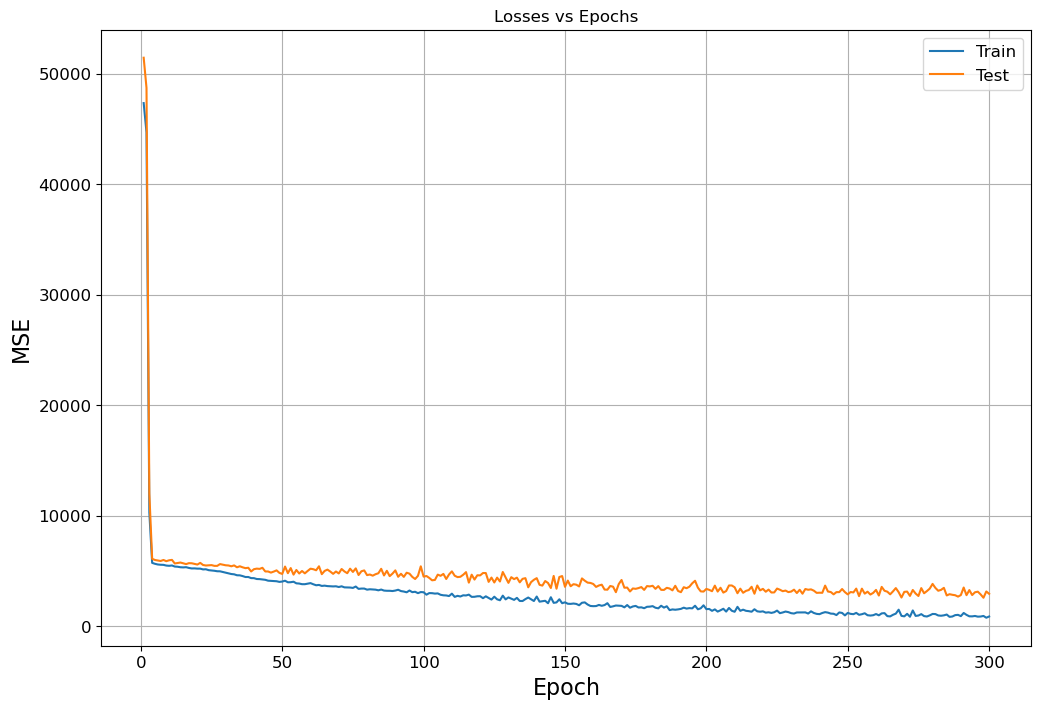

In [202]:
# Plot training progress
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(np.arange(1,n_epochs+1),losses_train, label="Train")
ax.plot(np.arange(1,n_epochs+1),losses_test, label="Test")
ax.set(title="Losses vs Epochs", xlabel = "Epoch", ylabel = "MSE")
ax.legend()
plt.grid()
plt.show()

We evaluate the performance of our model on the train and test sets.

In [203]:
y_hat_train, _ = mlp.predict(X_train.to_numpy())
y_hat_test, _ = mlp.predict(X_test.to_numpy())

print(f'Train set: MSE={losses_train[-1]} | R^2={r2_score(y_train.to_numpy(), y_hat_train)}')
print(f'Test set: MSE={losses_test[-1]} | R^2={r2_score(y_test.to_numpy(), y_hat_test)}')

Train set: MSE=884.1597711321709 | R^2=0.8665876353071774
Test set: MSE=2934.729984298217 | R^2=0.5554851074707505


**Analysis:**
- The model performs very well on the training set with a 'small' MSE of $884$ and a very good $R^2$ score of $0.87$.
- However, the model seems to generalise less effectively, with a higher MSE of $2935$ and a $R^2$ score of $0.56$, which is not optimal.

<a name="task-122"></a>

### (1.2.2) [(index)](#index-task-122)

Just to make sure we use the original data.

In [204]:
# We seperate the training features into X_train (by extracting all columns except 'Capacitance')
# and y_train which corresponds to the column 'Capacitance' (7th column): our targets.
X_train = data_train_T1.drop(data_train_T1.columns[6], axis=1)
y_train = data_train_T1[data_train_T1.columns[6]] #We keep the column 'Capacitance' of the data as our targets

# Similarly for the test set
X_test = data_test_T1.drop(data_test_T1.columns[6], axis=1)
y_test = data_test_T1[data_test_T1.columns[6]] #We keep the column 'Capacitance' of the data as our targets

In [205]:
# Standardise train and test data
X_test = standardise(X_test, X_train_=X_train)
X_train = standardise(X_train)

We will now use a different optimiser to train the MLP: SGD with momentum. We first redefine the MLP class in order to implement/store the **W_v** and **b_v** terms for the computation of the momentum at each hidden unit.

In [206]:
class MLP_momentum:
    """
    This class represents a Multi-Layer Perceptron (MLP), that we use to encapsulate two components:
        1. layers: the sequence of layers, where each layer is stored in
            a dictionary in the format {"W": np.ndarray, "b": np.ndarray},
            where "W" points to the weights array, and "b" points to
            the bias vector.
        2. rng: a pseudo random number generator (RNG) initialised to generate
            the random weights in a reproducible manner between different
            runtime sessions.
    This class is also shipped with methods that perform essential operations
    with a MLP, including:
        - add_layers: which creates a new layer with specified dimensions.
        - predict: applies the MLP forward pass to make predictions and produces
            a computational graph for the forward pass that can be used to
            compute gradients using backpropagation algorithm.
        in addition to other light functions that return simple statistics about
        the MLP.
    """
    
    def __init__(self, seed=42):
        self.layers = []
        self.rng = np.random.default_rng(seed)

    def n_parameters(self):
        """Return the total number of parameters of weights and biases."""
        return sum(l["b"].size + l["W"].size for l in self.layers)

    def n_layers(self):
        """Return current number of MLP layers."""
        return len(self.layers)

    def layer_dim(self, index):
        """Retrieve the dimensions of the MLP layer at `index`."""
        return self.layers[index]["W"].shape

    def add_layer(self, in_dim, out_dim, activation="identity"):
        """
        Add fully connected layer to MLP.
        Args:
            in_dim (int): The output dimension of the layer.
            out_dim (int): The input dimension of the layer.
            activation (str): The activation function name.
        """
        
        # Check if input-dimension matches output-dimension of previous layer
        if self.n_layers() > 0:
            last_out_dim, _ = self.layer_dim(-1)
            assert in_dim == last_out_dim, f"Input-dimension {in_dim} does not match output-dimension {last_out_dim} of previous layer."

        # The first layer, in our convention illustrated, does not apply activation on the input features X.
        if self.n_layers() == 0:
            assert activation == "identity", "Should not apply activations on the input features X, use Identity function for the first layer."


        # Store each layer as a dictionary in the list
        self.layers.append({
            "index": len(self.layers),
            # Apply Glorot initialisation for weights.
            "W": self.rng.normal(size=(out_dim, in_dim)) * np.sqrt(2. / (in_dim + out_dim)),
            # Initialise bias vector with zeros.
            "b": np.zeros(out_dim),
            # Initialise momentum vector for W with zeros.
            "v_W": np.zeros((out_dim, in_dim)),
            # Initialise momentum vector for b with zeros.
            "v_b": np.zeros(out_dim),
            # Store the activation function (as string)
            "activation": activation
        })


    def predict(self, X):
        """
        Apply the forward pass on the input X and produce prediction and the
        forward computation graph.
        Arg:
            X (np.ndarray): Feature matrix.
        Return:
            (np.ndarray, List[Dict[str, np.ndarray]]): A tuple of the
            predictions and the computation graph as a sequence of intermediate
            values through the MLP, specifically each layer will have a corresponding
            intermediate values {"a": np.ndarray, "h": np.ndarray}, as shown in the
            attached diagram above.
        """
        
        # We assume that we work with a batch of examples (ndim==2).
        if X.ndim == 1:
            # If one example passed, add a dummy dimension for the batch.
            X = X.reshape(1, -1)

        # Store pre- and post-activations in list
        forward_pass = [{"index": 0, "a": X, "h": X}]

        # Iterate through hidden layers
        for k in range(1, len(self.layers)):
            # Compute pre-activations
            a = dense(forward_pass[k - 1]["h"], self.layers[k - 1]["W"], self.layers[k - 1]["b"])
            activation = activation_table[self.layers[k]["activation"]]
            forward_pass.append({"index": k, "a" : a, "h" : activation(a)})

        y_hat = dense(forward_pass[-1]["h"], self.layers[-1]["W"], self.layers[-1]["b"])
        # Predicted target is output of last layer
        return y_hat, forward_pass

Implementation of the SGD step with momentum.

In [207]:
def sgd_step_momentum(X, y, mlp, learning_rate = 5e-5, beta=0.4):
    """
    Apply a stochastic gradient descent with momentum step using the sampled batch.
    Args:
        X (np.ndarray): The input features array batch, with dimension (N, D).
        y (np.ndarray): The ground-truth of the batch, with dimension (N, 1).
        learning_rate (float): The learning rate multiplier for the update steps in SGD.
        beta (int): momentum parameter.
    Return:
        (List[Dict[str, np.ndarray]]): The updated layers after applying SGD.
    """
    
    # Compute the forward pass.
    y_hat, forward_pass = mlp.predict(X)

    # Compute the partial derivative of the loss w.r.t. to predictions 'y_hat'.
    delta_output = grad_mse_loss(y, y_hat)

    # Apply backpropagation algorithm to compute the gradients of the MLP parameters.
    gradients = backpropagate(mlp.layers, forward_pass, delta_output)

    updated_layers = []
    for layer, grad in zip(mlp.layers, gradients):
        v_W = beta * layer["v_W"] + learning_rate * grad["W"] # Update of the momentum vector for W
        v_b = beta * layer["v_b"] + learning_rate * grad["b"] # Update of the momentum vector for b
        W = layer["W"] - v_W # Update of W using momentum
        b = layer["b"] - v_b # Update of b using momentum
        updated_layers.append({"W": W, "b": b, "v_W": v_W, "v_b": v_b,
                               # Keep the activation function.
                               "activation": layer["activation"],
                               "index": layer["index"]})
    return updated_layers

In [208]:
def sgd_momentum(X_train, y_train, X_test, y_test, mlp, learning_rate = 5e-5, beta=0.4, n_epochs=300, minibatchsize=8, seed=42):
    """
    Run the Stochastic Gradient Descent with momentum algorithm to optimise the parameters of MLP model to fit it on
    the training data using MSE loss.
    Args:
        X_train (np.ndarray): The training data features, with shape (N, D).
        y_train (np.ndarray): The training data ground-truth, with shape (N, 1).
        X_test (np.ndarray): The testing data features, with shape (N_test, D).
        y_test (np.ndarray): The testing data ground-truth, with shape (N_test, 1).
        mlp (MLP): The MLP object enacpsulating the MLP model.
        learning_rate (float): The learning_rate multiplier used in updating the parameters at each iteration.
        n_epochs (int): The number of training cycles that each covers the entire training examples.
        minibatchsize (int): The batch size used in each SGD step.
        seed (int): A seed for the RNG to ensure reproducibility across runtime sessions.
    """

    # Get random number generator
    rng = np.random.default_rng(seed)

    # Compute number of iterations per epoch
    n_iterations = int(len(y_train) / minibatchsize)

    # Store losses
    losses_train = []
    losses_test = []

    epochs_bar = tqdm(range(n_epochs))
    for i in epochs_bar:

        # Shuffle data
        p = rng.permutation(len(y_train))
        X_train_shuffled = X_train[p]
        y_train_shuffled = y_train[p]

        for j in range(n_iterations):
            # Get batch
            X_batch = X_train_shuffled[j*minibatchsize : (j+1)*minibatchsize]
            y_batch = y_train_shuffled[j*minibatchsize : (j+1)*minibatchsize]

            # Apply sgd step with momentum
            updated_layers = sgd_step_momentum(X_batch, y_batch, mlp, learning_rate=learning_rate, beta=beta)

            # Update weights and biases of MLP
            mlp.layers = updated_layers

        # Compute loss at the end of each epoch
        y_hat_train, _ = mlp.predict(X_train)
        losses_train.append(mse_loss(y_train, y_hat_train).squeeze())
        y_hat_test, _ = mlp.predict(X_test)
        losses_test.append(mse_loss(y_test, y_hat_test).squeeze())
        epochs_bar.set_description(f'train_loss: {losses_train[-1]:.2f}, '
                                   f'test_loss: {losses_test[-1]:.2f}, '
                                   f'train_R^2: {r2_score(y_train, y_hat_train):.2f} '
                                   f'test_R^2: {r2_score(y_test, y_hat_test):.2f} ')
    
    return mlp, losses_train, losses_test

Creation and traning of our MLP using SGD with momentum.

In [209]:
mlp_m = MLP_momentum(seed=2)
mlp_m.add_layer(12, 50)
mlp_m.add_layer(50, 50, "fun")
mlp_m.add_layer(50, 1, "fun")

n_epochs = 300
mlp_m, losses_train_m, losses_test_m = sgd_momentum(X_train.to_numpy(), y_train.to_numpy(), X_test.to_numpy(), y_test.to_numpy(), mlp_m, learning_rate = 5e-5, beta=0.4, n_epochs=300, minibatchsize=8, seed=42) 

  0%|          | 0/300 [00:00<?, ?it/s]

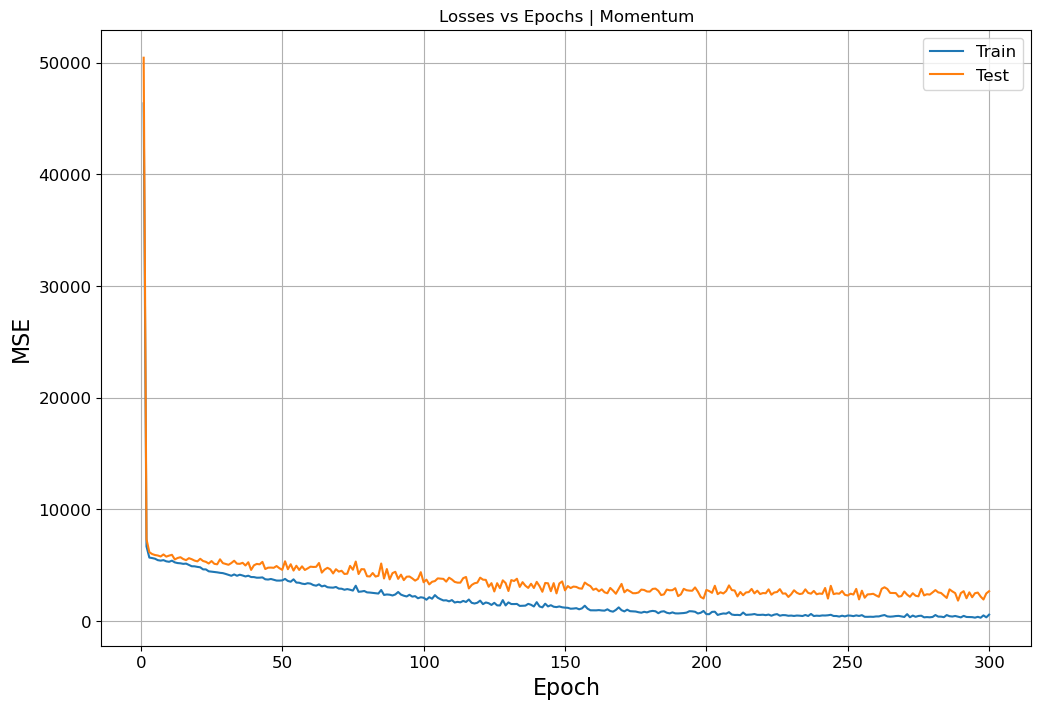

In [210]:
# Plot training progress
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(np.arange(1,n_epochs+1),losses_train_m, label="Train")
ax.plot(np.arange(1,n_epochs+1),losses_test_m, label="Test")
ax.set(title="Losses vs Epochs | Momentum", xlabel = "Epoch", ylabel = "MSE")
ax.legend()
plt.grid()
plt.show()

In [211]:
y_hat_train_momentum, _ = mlp_m.predict(X_train.to_numpy())
y_hat_test_momentum, _ = mlp_m.predict(X_test.to_numpy())

print(f'Train set (MLP with momentum): MSE={mse_loss(y_train.to_numpy(), y_hat_train_momentum).squeeze()} | R^2={r2_score(y_train.to_numpy(), y_hat_train_momentum)}')
print(f'Test set (MLP with momentum): MSE={mse_loss(y_test.to_numpy(), y_hat_test_momentum).squeeze()} | R^2={r2_score(y_test.to_numpy(), y_hat_test_momentum)}')

print(f'\nTrain set (MLP): MSE={mse_loss(y_train.to_numpy(), y_hat_train).squeeze()} | R^2={r2_score(y_train.to_numpy(), y_hat_train)}')
print(f'Test set (MLP): MSE={mse_loss(y_test.to_numpy(), y_hat_test).squeeze()} | R^2={r2_score(y_test.to_numpy(), y_hat_test)}')

print('\nTrain set (RF (1.1.2)): MSE={} | R^2={}'.format(*rf_score_train))
print('Test set (RF (1.1.2)): MSE={} | R^2={}'.format(*rf_score_test))

Train set (MLP with momentum): MSE=580.0956564431973 | R^2=0.9124683843339519
Test set (MLP with momentum): MSE=2679.5866394696905 | R^2=0.5941309171748167

Train set (MLP): MSE=884.1597711321709 | R^2=0.8665876353071774
Test set (MLP): MSE=2934.729984298217 | R^2=0.5554851074707505

Train set (RF (1.1.2)): MSE=1284.5932239053573 | R^2=0.8061655537096689
Test set (RF (1.1.2)): MSE=3190.8231385143285 | R^2=0.5166954329409239


**Analysis:**
First of all, the MLP with momentum performs better than the MLP on both the train and test sets: 
   - Train set: MSE of $580$ and a very good $R^2$ score of $0.91$ for MLP with momentum (compared to $884$ and $0.87$ for MLP).
   - Test set: MSE of $2680$ and a $R^2$ score of $0.59$ for MLP with momentum (compared to $2935$ and $0.56$ for MLP).
    
Nevertheless, both MLP and MLP with momentum do not seem to generalise perfectly to unseen data.

Overall, both MLP and MLP with momentum outperform the Random forest (**1.1.2**) on both the train set and test set. Finally, considering also the time taken to train the Random forest and the MLP, MLP appears to be a more efficient model for this task. However, a $R^2$ score of $0.59$ (with momentum) is still not optimal.

<a name="task-123"></a>

### (1.2.3) [(index)](#index-task-123)

Just to make sure we use the original data.

In [212]:
# We seperate the training features into X_train (by extracting all columns except 'Capacitance')
# and y_train which corresponds to the column 'Capacitance' (7th column): our targets.
X_train = data_train_T1.drop(data_train_T1.columns[6], axis=1)
y_train = data_train_T1[data_train_T1.columns[6]] #We keep the column 'Capacitance' of the data as our targets

# Similarly for the test set
X_test = data_test_T1.drop(data_test_T1.columns[6], axis=1)
y_test = data_test_T1[data_test_T1.columns[6]] #We keep the column 'Capacitance' of the data as our targets

In [213]:
# Standardise train and test data
X_test = standardise(X_test, X_train_=X_train)
X_train = standardise(X_train)

We will now perform what is called linear regression with quadratic basis functions. First of all, we need to extend the set of 12 features to a set containing also the quadratic terms.

In [214]:
def extend_features(X):
    X_prime = X.copy() # Copy to make sure we do not modify original features
    for i in range(X.shape[1]):
        for j in range(i, X.shape[1]):
            X_prime[f'Quad{i,j}'] = X_prime.iloc[:,i] * X_prime.iloc[:,j] # Add quad features
    return X_prime

In [215]:
X_prime_train = extend_features(X_train) # Extended X_train
X_prime_test = extend_features(X_test) # Extended X_test

Let's define `ridge_estimate()` which implements ridge regression with a penalty term $\lambda$ to estimate the parameters.

In [216]:
def ridge_estimate(X, y, penalty):
    """
    Apply RIDGE regression.
    Args:
        X (np.ndarray): Matrix of training inputs (N, D).
        y (np.ndarray): Vector of training targets/observations (N, 1).
        penalty (float): Penalty term in ridge regression.
    Returns: 
        beta_ridge (np.ndarray): Maximum likelihood parameters (D, 1).
    """
    
    N, D = X.shape
    X_aug = np.hstack([np.ones((N,1)), X]) # Augmented training inputs of size N x (D+1)
    N_aug, D_aug = X_aug.shape
    I = np.identity(D_aug)
    I[0] = 0.0 # Penalty excludes the bias term.
    beta_ridge = np.linalg.solve(X_aug.T @ X_aug + penalty * I, X_aug.T @ y)
    return beta_ridge

Let's analyse the distribution of the parameters for different values of $\lambda$.

Text(0.5, 0.98, 'Distributions of $\\beta$')

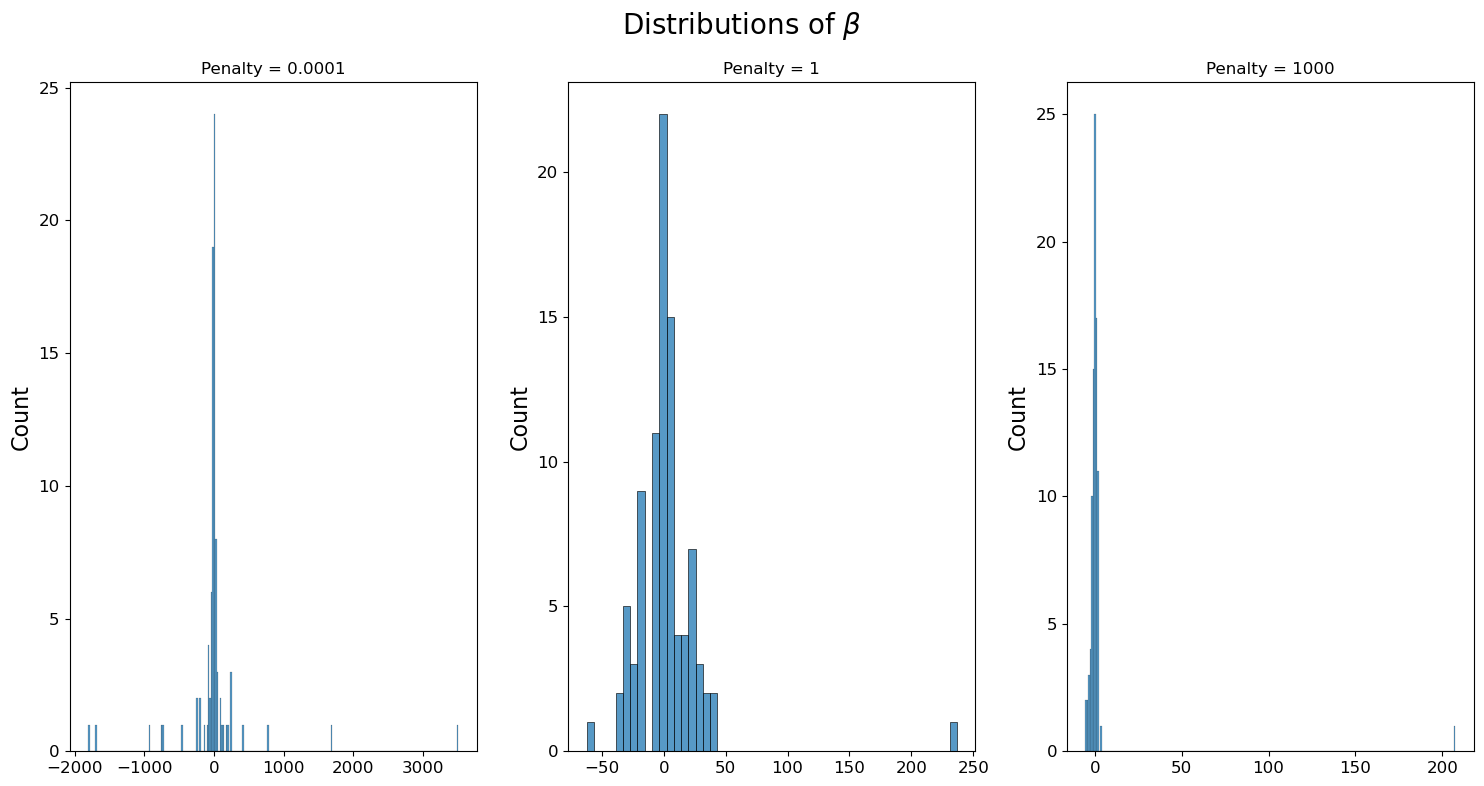

In [217]:
lambda_range = [0.0001, 1, 1000]
beta_hat = np.zeros((len(lambda_range),X_prime_train.shape[1]+1))

fig, plots = plt.subplots(1, 3, figsize=(15,8), tight_layout=True)
for i, penalty in enumerate(lambda_range):
    beta_hat[i,:] = ridge_estimate(X_prime_train, y_train, penalty)
    sns.histplot(beta_hat[i,:], ax = plots[i]) # Plot the distribution of the parameters
    plots[i].set_title(f'Penalty = {penalty}')
fig.suptitle(r'Distributions of $\beta$')

**Comment about the distributions:** On these three plots, we observe that as $\lambda$ increases, more $\beta^{(i)}$ tend to $0$. This observation aligns with the idea behind ridge regression. As $\lambda$ increases, the penalty term $\lambda\sum|\beta^{(i)}|$ also increases, and the only way to minimise it is to decrease the $\beta^{(i)}$ towards $0$ (even setting some equal to $0$).

In [218]:
def ridge_predict(X_train, y_train, X_test, penalty):
    """
    RIDGE prediction.
    Args:
        X_train (np.ndarray): Matrix of training inputs (N, D).
        y_train (np.ndarray): Vector of training targets/observations (N, 1).
        X_test (np.ndarray): Matrix of testing inputs.
        penalty (float): Penalty term in ridge regression.
    Return: 
        Predicted values (np.ndarray).
    """
    
    beta_ridge = ridge_estimate(X_train, y_train, penalty)
    
    N, _ = X_test.shape
    X_test_aug = np.hstack([np.ones((N,1)), X_test])
    
    return X_test_aug @ beta_ridge # Compute the predicted values

Let's evaluate the performance of our model.

In [219]:
def ridge_score(y_pred, y_test):
    """
    RIDGE score.
    Args:
        y_pred (np.ndarray): Vector of predicted values.
        y_test (np.ndarray): Vector of testing inputs.
    Returns: 
        mse score (float).
        r2_score (float between 0 and 1).
    """
    
    #MSE
    mse = np.mean((y_pred - y_test)**2)
    
    #R2 score
    numerator = np.sum((y_test - y_pred)**2)
    y_avg = np.mean(y_test)
    denominator = np.sum((y_test - y_avg)**2)
    r2_score = 1 - numerator/denominator
    
    return mse, r2_score

We carry out a 5-fold cross-validation, using the MSE as performance metric, to find the best penalty term $\lambda$ to fit our ridge regression.

In [220]:
def penalty_cross_validation(X, y, folds, penalty):
    scores = []
    
    for i in range(len(folds)):
        val_indexes = folds[i]
        train_indexes = list(set(range(y.shape[0])) - set(val_indexes))
        
        X_train_i = X.iloc[train_indexes, :]
        y_train_i = y[train_indexes]
        
        X_val_i = X.iloc[val_indexes, :]
        y_val_i = y[val_indexes]
        
        y_pred_i = ridge_predict(X_train_i, y_train_i, X_val_i, penalty)

        score_i = ridge_score(y_pred_i, y_val_i)[0]
        scores.append(score_i)
    
    # Return the average MSE score
    return sum(scores) / len(scores)

In [221]:
def choose_best_penalty(X, y, folds, penalty_range, print_progression=False):
    penalty_scores = np.zeros((len(penalty_range),))
    
    for i, penalty in enumerate(penalty_range):
        penalty_scores[i] = penalty_cross_validation(X, y, folds, penalty)
        
        if (i%50 == 0) and (print_progression == True):
            print(f'MSE_SCORE@penalty={penalty}: {penalty_scores[i]:.3f}')
        
    best_penalty_index = np.argmin(penalty_scores) # Index of the penalty term with the smallest score
    
    return penalty_scores, penalty_range[best_penalty_index]

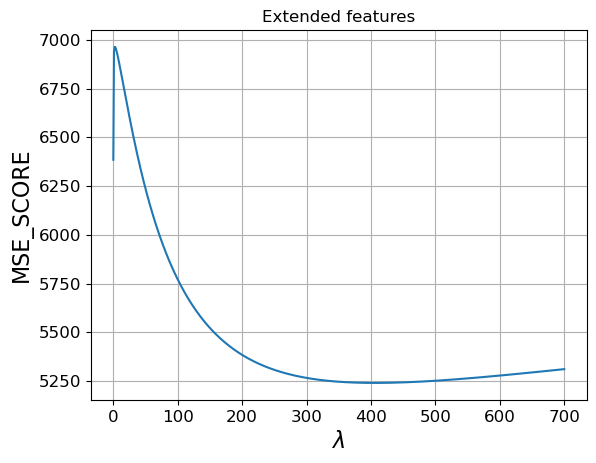

Best penalty for extended features: 406


In [222]:
folds_indexes = np.array_split(np.arange(len(y_train)), 5)

penalty_scores, best_penalty_extended = choose_best_penalty(X_prime_train, y_train, folds_indexes, np.arange(0,701), print_progression=False)

plt.plot(np.arange(0,701), penalty_scores)
plt.xlabel(r'$\lambda$')
plt.ylabel('MSE_SCORE')
plt.title('Extended features')
plt.grid()
plt.show()

print('Best penalty for extended features:', best_penalty_extended)

We then carry out a ridge regression (and linear regression) on the original features.

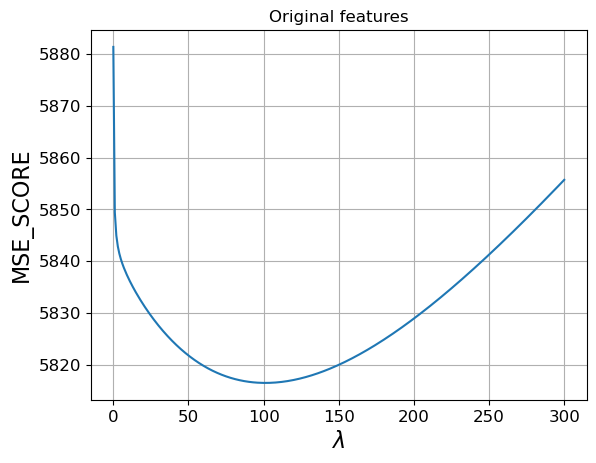

Best penalty for original features: 101


In [223]:
# Find best penalty for the original features
penalty_scores_original, best_penalty_original = choose_best_penalty(X_train, y_train, folds_indexes, np.arange(0,301), print_progression=False)

plt.plot(np.arange(0,301), penalty_scores_original)
plt.xlabel(r'$\lambda$')
plt.ylabel('MSE_SCORE')
plt.title('Original features')
plt.grid()
plt.show()

print('Best penalty for original features:', best_penalty_original)

Finally, we compare the performances of the four models: Linear and Ridge for both the extended and original features. We also compare with the MLP model implemented above.

In [224]:
# For the extended features
y_pred_linear_extended = ridge_predict(X_prime_train, y_train, X_prime_test, 0)
y_pred_ridge_extended = ridge_predict(X_prime_train, y_train, X_prime_test, best_penalty_extended)

# For the original features
y_pred_linear_original = ridge_predict(X_train, y_train, X_test, 0)
y_pred_ridge_original = ridge_predict(X_train, y_train, X_test, best_penalty_original)


print('Test set (Linear extended): MSE={} | R^2={}'.format(*ridge_score(y_pred_linear_extended, y_test)))
print('Test set (Ridge extended): MSE={} | R^2={}'.format(*ridge_score(y_pred_ridge_extended, y_test)))

print('\nTest set (Linear original features): MSE={} | R^2={}'.format(*ridge_score(y_pred_linear_original, y_test)))
print('Test set (Ridge original features): MSE={} | R^2={}'.format(*ridge_score(y_pred_ridge_original, y_test)))

print(f'\nTest set (MLP with momentum): MSE={mse_loss(y_test.to_numpy(), y_hat_test_momentum).squeeze()} | R^2={r2_score(y_test.to_numpy(), y_hat_test_momentum)}')
print(f'Test set (MLP): MSE={mse_loss(y_test.to_numpy(), y_hat_test).squeeze()} | R^2={r2_score(y_test.to_numpy(), y_hat_test)}')

Test set (Linear extended): MSE=5139.661027577239 | R^2=0.2215107074470435
Test set (Ridge extended): MSE=4989.080670133863 | R^2=0.24431866993902196

Test set (Linear original features): MSE=5794.722718697646 | R^2=0.12229044568996505
Test set (Ridge original features): MSE=5859.4976569625605 | R^2=0.11247917689335629

Test set (MLP with momentum): MSE=2679.5866394696905 | R^2=0.5941309171748167
Test set (MLP): MSE=2934.729984298217 | R^2=0.5554851074707505


**Analysis:** First of all, we notice that MLP and MLP with momentum both significantly outperform the four other models on the test set: about half of the MSE and twice the $R^2$ score. Hence, MLP appears to generalise better to unseen data.

Furthermore, when comparing the performance between original and extended features, we observe that both Linear and Ridge with extended features perform better on the test set compared to the ones with original features. Thus, adding these quadratic basis functions seems to improve the model's generalisation to unseen data.

Finally, among the models using extended features, Ridge performs slightly better than Linear as expected.



---



<a name="task-2"></a>

# (2) Task 2: Classification [(index)](#index-task-2)

In [225]:
data_train_T2 = pd.read_csv('brain_cancer_samples.csv')
data_test_T2 = pd.read_csv('brain_cancer_test.csv')

data_train_T2.head()
#sns.pairplot(data_train_T2)

,Patient ID,2D Surface,Contour Size,Total Surface,Density,Diameter,Primary Axis,Shape Variation,Location,Eccentricity_Real,Eccentricity_Imag,Class
0,1,1325.5,160.124890,1518.5,0.872901,41.081371,36.290924,53.992371,2,6.750000e-17,1.101565,1
1,2,81.5,39.556349,88.0,0.926136,10.186708,8.801125,15.591203,2,8.950000e-17,1.462264,1
2,3,57177.0,912.607209,57611.0,0.992467,269.814784,234.644165,312.589264,4,5.390000e-17,0.880179,0
3,4,135.0,92.083260,206.0,0.655340,13.110581,6.568726,40.183521,3,3.700000e-16,6.035112,0
4,5,6653.0,1525.307779,84025.5,0.079178,92.037290,383.980133,402.407623,3,1.920000e-17,0.313504,1


In [226]:
# We seperate the training features into X_train (by extracting all columns except the first 'Patient ID' and last ones 'Class')
# and y_train which corresponds to the column 'Class' (last column): our targets.
X_train = data_train_T2.iloc[:,1:-1]
y_train = data_train_T2.iloc[:,-1] #We keep the column 'Class' of the data as our targets

# Similarly for the test set
X_test = data_test_T2.iloc[:,1:-1]
y_test = data_test_T2.iloc[:,-1] #We keep the column 'Class' of the data as our targets

As k-Nearest Neighbours is a distance-based classifier, we decide to standardise the data.

In [227]:
# Standardise train and test data
X_test = standardise(X_test, X_train_=X_train)
X_train = standardise(X_train)

<a name="task-21"></a>

## (2.1) k-Nearest Neighbours [(index)](#index-task-21)

In [228]:
def euclidian_distance(p, q):
    return np.sqrt(np.sum((p-q)**2, axis=1))

<a name="task-211"></a>

### (2.1.1) [(index)](#index-task-211)

We find the _k_ nearest neighbours in our training set for every test data point. The majority of labels of the _k_ closest training points determines the label of the test point.

In [229]:
def k_neighbours(X_train, X_test, k, return_distance=False):
    """
    Find k nearest neighbours.
    Args:
        X_train (np.ndarray): Matrix of training inputs (N, p).
        X_test (np.ndarray): Matrix of testing inputs.
        k (int): Number of neighbours.
        return_distance (bool).
    Returns: 
        indexes of k nearest neighbours (np.ndarray).
        (if return_distance): distances with k nearest neighbours (np.ndarray).
    """
    
    n_neighbours = k
    dist = []
    neigh_ind = []

    # Compute distance from each point x_test in X_test to all points in X_train
    if len(X_test.shape) == 1:
        point_dist = [euclidian_distance(X_test, X_train)]
    else:
        point_dist = [euclidian_distance(x_test, X_train) for x_test in X_test]

    # Determine which k training points are closest to each test point
    for row in point_dist:
        enum_neigh = enumerate(row)
        sorted_neigh = sorted(enum_neigh, key=lambda x: x[1])[:k]

        ind_list = [tup[0] for tup in sorted_neigh]
        dist_list = [tup[1] for tup in sorted_neigh]
        
        dist.append(dist_list)
        neigh_ind.append(ind_list)

    # Return distances together with indices of k nearest neighbours
    if return_distance:
        return np.array(neigh_ind), np.array(dist)

    return np.array(neigh_ind)

Once we know which _k_ neighbours are closest to our test points, we can predict the labels of these test points.

We implement this in a "pythonic" way and call the previous function `k_neighbours()` _within_ the next function `k_predict()`.

Our `k_predict()` function determines how any point $x_\text{test}$ in the test set is classified. Here, we only consider the case where each of the *k* neighbours contributes equally to the classification of $x_\text{test}$.

In [230]:
def k_predict(X_train, y_train, X_test, k):
    """
    Predict labels of the samples in X_test.
    Args:
        X_train (np.ndarray): Matrix of training inputs (N, p).
        y_train (np.ndarray): Vector of training targets/observations (N, 1).
        X_test (np.ndarray): Matrix of testing inputs (N_test, p).
        k (int): Number of neighbours.
    Returns: 
        Predicted labels (np.ndarray)
    """

    neighbours = k_neighbours(X_train, X_test, k)
    y_pred = np.array([np.argmax(np.bincount(y_train[neighbour])) for neighbour in neighbours])

    return y_pred

We evaluate its performance on the test set with as metric the micro-averaged accuracy.

In [231]:
def k_MiAA(y_pred, y_test):
    """
    Micro-averaged accuracy.
    Args:
        y_pred (np.ndarray): Vector of predicted labels (N, 1).
        y_test (np.ndarray): Vector of testing targets/observations (N, 1).
    Return:
        MiAA (float).
    """
    
    tp_0 = np.sum((y_test == 0) & (y_pred == 0))
    tp_1 = np.sum((y_test == 1) & (y_pred == 1))
    tp_2 = np.sum((y_test == 2) & (y_pred == 2))
    
    return (tp_0 + tp_1 + tp_2) / len(y_test)

We carry out a 5-fold cross-validation to determine the best _k_ for our model.

In [232]:
def k_cross_validation(X, y, folds, k):
    scores = []
    
    for i in range(len(folds)):
        val_indexes = folds[i]
        train_indexes = list(set(range(y.shape[0])) - set(val_indexes))
        
        X_train_i = X.iloc[train_indexes, :]
        y_train_i = y[train_indexes]
        
        X_val_i = X.iloc[val_indexes, :]
        y_val_i = y[val_indexes]
        
        y_pred_i = k_predict(X_train_i.to_numpy(), y_train_i.to_numpy(), X_val_i.to_numpy(), k)
        
        score_i = k_MiAA(y_pred_i, y_val_i.to_numpy())
        scores.append(score_i)
    
    # Return the average score
    return sum(scores) / len(scores)

In [233]:
def choose_best_k(X, y, folds, k_range, print_progression=False):
    k_scores = np.zeros((len(k_range),))
    
    for i, k in enumerate(k_range):
        k_scores[i] = k_cross_validation(X, y, folds, k)
        if print_progression:
            print(f'MiAA@k={k}: {k_scores[i]:.3f}')
        
    best_k_index = np.argmax(k_scores)
    return k_scores, k_range[best_k_index]

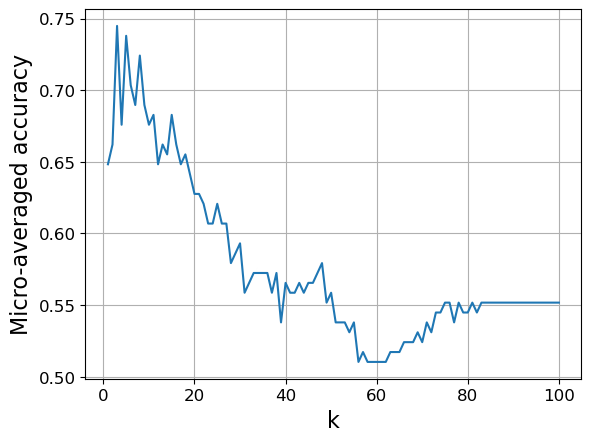

Best k is: 3


In [234]:
folds_indexes = np.split(np.arange(len(y_train)), 5)

k_scores, best_k = choose_best_k(X_train, y_train, folds_indexes, np.arange(1,101), print_progression=False)

plt.plot(np.arange(1,101), k_scores)
plt.xlabel('k')
plt.ylabel('Micro-averaged accuracy')
plt.grid()
plt.show()

print('Best k is:', best_k)

Print the performance (micro-averaged accuracy) of our model on the test set X_test.

In [235]:
y_pred = k_predict(X_train.to_numpy(), y_train.to_numpy(), X_test.to_numpy(), best_k)
print('MiAA on test set:', k_MiAA(y_pred, y_test.to_numpy()))

MiAA on test set: 0.6666666666666666


We visualise the number of samples for each class; the goal is to determine if any class is in majority or minority among the others.

Text(0, 0.5, 'Numbers')

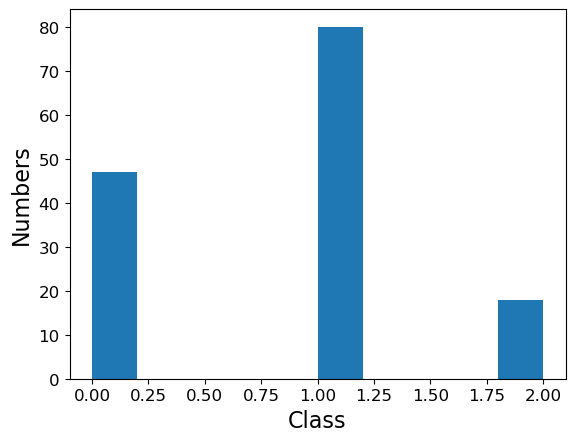

In [236]:
plt.hist(y_train)
plt.xlabel('Class')
plt.ylabel('Numbers')

On this histogram we clearly observe that _Class 2_ is in minority. Let's analyse how our model took this observation into account.

We define several metrics.

In [237]:
def k_MiAP(y_pred, y_test):
    """
    Micro-averaged precision.
    Args:
        y_pred (np.ndarray): Vector of predicted labels (N, 1).
        y_test (np.ndarray): Vector of testing targets/observations (N, 1).
    Return:
        MiAP (float).
    """
    
    tp_0 = np.sum((y_test == 0) & (y_pred == 0))
    tp_1 = np.sum((y_test == 1) & (y_pred == 1))
    tp_2 = np.sum((y_test == 2) & (y_pred == 2))
    
    fp_0 = np.sum((y_test != 0) & (y_pred == 0))
    fp_1 = np.sum((y_test != 1) & (y_pred == 1))
    fp_2 = np.sum((y_test != 2) & (y_pred == 2))
    
    return (tp_0 + tp_1 + tp_2) / (tp_0 + tp_1 + tp_2 + fp_0 + fp_1 + fp_2)

In [238]:
def k_MaAA(y_pred, y_test):
    """
    Macro-averaged accuracy.
    Args:
        y_pred (np.ndarray): Vector of predicted labels (N, 1).
        y_test (np.ndarray): Vector of testing targets/observations (N, 1).
    Return:
        MaAA (float).
    """
    
    tp_0 = np.sum((y_test == 0) & (y_pred == 0))
    tp_1 = np.sum((y_test == 1) & (y_pred == 1))
    tp_2 = np.sum((y_test == 2) & (y_pred == 2))
    
    tn_0 = np.sum((y_test != 0) & (y_pred != 0))
    tn_1 = np.sum((y_test != 1) & (y_pred != 1))
    tn_2 = np.sum((y_test != 2) & (y_pred != 2))
    
    fp_0 = np.sum((y_test != 0) & (y_pred == 0))
    fp_1 = np.sum((y_test != 1) & (y_pred == 1))
    fp_2 = np.sum((y_test != 2) & (y_pred == 2))
    
    fn_0 = np.sum((y_test == 0) & (y_pred != 0))
    fn_1 = np.sum((y_test == 1) & (y_pred != 1))
    fn_2 = np.sum((y_test == 2) & (y_pred != 2))
    
    
    acc_0 = (tp_0 + tn_0) / (tp_0 + tn_0 + fp_0 + fn_0)
    acc_1 = (tp_1 + tn_1) / (tp_1 + tn_1 + fp_1 + fn_1)
    acc_2 = (tp_2 + tn_2) / (tp_2 + tn_2 + fp_2 + fn_2)
    
    return (acc_0 + acc_1 + acc_2) / 3

In [239]:
def k_MaAP(y_pred, y_test):
    """
    Macro-averaged precision.
    Args:
        y_pred (np.ndarray): Vector of predicted labels (N, 1).
        y_test (np.ndarray): Vector of testing targets/observations (N, 1).
    Return:
        MaAP (float).
    """
    
    tp_0 = np.sum((y_test == 0) & (y_pred == 0))
    tp_1 = np.sum((y_test == 1) & (y_pred == 1))
    tp_2 = np.sum((y_test == 2) & (y_pred == 2))
    
    fp_0 = np.sum((y_test !=  0) & (y_pred == 0))
    fp_1 = np.sum((y_test !=  1) & (y_pred == 1))
    fp_2 = np.sum((y_test !=  2) & (y_pred == 2))
    
    prec_0 = tp_0 / (tp_0 + fp_0)
    prec_1 = tp_1 / (tp_1 + fp_1)
    prec_2 = tp_2 / (tp_2 + fp_2)

    return (prec_0 + prec_1 + prec_2) / 3

In [240]:
def k_CWAA(y_pred, y_test):
    """
    Class-weighted accuracy.
    Args:
        y_pred (np.ndarray): Vector of predicted labels (N, 1).
        y_test (np.ndarray): Vector of testing targets/observations (N, 1).
    Return:
        CWAA (float).
    """
    
    freq_0 = np.sum(y_test == 0) / len(y_test)
    freq_1 = np.sum(y_test == 1) / len(y_test)
    freq_2 = np.sum(y_test == 2) / len(y_test)
    
    tp_0 = np.sum((y_test == 0) & (y_pred == 0))
    tp_1 = np.sum((y_test == 1) & (y_pred == 1))
    tp_2 = np.sum((y_test == 2) & (y_pred == 2))
    
    tn_0 = np.sum((y_test != 0) & (y_pred != 0))
    tn_1 = np.sum((y_test != 1) & (y_pred != 1))
    tn_2 = np.sum((y_test != 2) & (y_pred != 2))
    
    fp_0 = np.sum((y_test != 0) & (y_pred == 0))
    fp_1 = np.sum((y_test != 1) & (y_pred == 1))
    fp_2 = np.sum((y_test != 2) & (y_pred == 2))
    
    fn_0 = np.sum((y_test == 0) & (y_pred != 0))
    fn_1 = np.sum((y_test == 1) & (y_pred != 1))
    fn_2 = np.sum((y_test == 2) & (y_pred != 2))
    
    prec_0 = (tp_0 + tn_0) / (tp_0 + tn_0 + fp_0 + fn_0)
    prec_1 = (tp_1 + tn_1) / (tp_1 + tn_1 + fp_1 + fn_1)
    prec_2 = (tp_2 + tn_2) / (tp_2 + tn_2 + fp_2 + fn_2)
    
    return (freq_0*prec_0 + freq_1*prec_1 + freq_2*prec_2) / (freq_0 + freq_1 + freq_2)

In [241]:
def k_CWAP(y_pred, y_test):
    """
    Compute class-weighted precision.
    Args:
        y_pred (np.ndarray): Vector of predicted labels (N, 1).
        y_test (np.ndarray): Vector of testing targets/observations (N, 1).
    Return:
        CWAP (float).
    """
    
    freq_0 = np.sum(y_test == 0) / len(y_test)
    freq_1 = np.sum(y_test == 1) / len(y_test)
    freq_2 = np.sum(y_test == 2) / len(y_test)
    
    tp_0 = np.sum((y_test == 0) & (y_pred == 0))
    tp_1 = np.sum((y_test == 1) & (y_pred == 1))
    tp_2 = np.sum((y_test == 2) & (y_pred == 2))
    
    fp_0 = np.sum((y_test !=  0) & (y_pred == 0))
    fp_1 = np.sum((y_test !=  1) & (y_pred == 1))
    fp_2 = np.sum((y_test !=  2) & (y_pred == 2))
    
    prec_0 = tp_0 / (tp_0 + fp_0)
    prec_1 = tp_1 / (tp_1 + fp_1)
    prec_2 = tp_2 / (tp_2 + fp_2)

    return (freq_0*prec_0 + freq_1*prec_1 + freq_2*prec_2) / (freq_0 + freq_1 + freq_2)

In [242]:
print('MiAA:', k_MiAA(y_pred, y_test.to_numpy()))
print('MiAP:', k_MiAP(y_pred, y_test.to_numpy()))
print('MaAA:', k_MaAA(y_pred, y_test.to_numpy()))
print('MaAP:', k_MaAP(y_pred, y_test.to_numpy()))
print('CWAA:', k_CWAA(y_pred, y_test.to_numpy()))
print('CWAP:', k_CWAP(y_pred, y_test.to_numpy()))

MiAA: 0.6666666666666666
MiAP: 0.6666666666666666
MaAA: 0.7777777777777777
MaAP: 0.7387533875338753
CWAA: 0.7147222222222223
CWAP: 0.6750406504065042


**Analysis**: From these results we can deduce that our model treats reasonably well the unbalance in the data. Indeed, both MiAA and MiAP give an overall assessment of the model's accuracy/precision, considering each instance equally, however, their score are not very high. Moreover, MaAA and MaAP provide the average accuracy/precision across all classes, without considering class imbalances; here again even if the scores are higher they are still not optimal. Finally, CWAA and CWAP provide an average accuracy/precision across all classes, considering class imbalances by weighting each class's accuracy by its proportion in the dataset; the scores are equivalent to the previous ones.

<a name="task-212"></a>

### (2.1.2) [(index)](#index-task-212)

We design a weighted version of kNN to improve the prediction of the minority class. My reweighting strategy is to define:

$$
weights = \frac{1}{distances}.
$$

Indeed, in doing this, the more the data point is close to our sample $x_{test}$ the more weight it will have. We then define the predicted labels $y_{pred}$ to be:

$$
y_{pred}^{(i)} = \underset{\text{c: class c}}{argmax}\left(\sum_{\text{k: k neighbour of $x^{(i)}$}}1_{\{class_k==c\}}*w_k^{(i)}\right).
$$

In [243]:
def k_weighted_predict(X_train, y_train, X_test, k):
    """
    Predict labels of the samples in X_test with weighting.
    Args:
        X_train (np.ndarray): Matrix of training inputs (N, p).
        y_train (np.ndarray): Vector of training targets/observations (N, 1).
        X_test (np.ndarray): Matrix of testing inputs (N_test, p).
        k (int): Number of neighbours.
    Returns: 
        Predicted labels (np.ndarray).
    """

    neighbours, distances = k_neighbours(X_train, X_test, k, return_distance=True)
    
    # Avoid division by 0 in exceptional cases (adding a small epsilon to ALL distances does not change the weighting scheme)
    epsilon = 1e-9
    weights = 1 / (distances + epsilon)
    
    class_0 = np.zeros(neighbours.shape[0])
    class_1 = np.zeros(neighbours.shape[0])
    class_2 = np.zeros(neighbours.shape[0])
    
    for ind, neighbour in enumerate(neighbours):
        class_0[ind] = np.sum((y_train[neighbour] == 0) * weights[ind])
        class_1[ind] = np.sum((y_train[neighbour] == 1) * weights[ind])
        class_2[ind] = np.sum((y_train[neighbour] == 2) * weights[ind])
    
    y_temp = np.vstack((class_0, class_1, class_2))
    y_pred = np.argmax(y_temp, axis=0)
    
    return y_pred

As asked, we set $k=best\_k$ which is the best _k_ obtained previously by cross-validation.

In [244]:
y_pred_weighted = k_weighted_predict(X_train.to_numpy(), y_train.to_numpy(), X_test.to_numpy(), k=best_k)

print('MiAA:', k_MiAA(y_pred_weighted, y_test.to_numpy()))
print('MiAP:', k_MiAP(y_pred_weighted, y_test.to_numpy()))
print('MaAA:', k_MaAA(y_pred_weighted, y_test.to_numpy()))
print('MaAP:', k_MaAP(y_pred_weighted, y_test.to_numpy()))

MiAA: 0.6833333333333333
MiAP: 0.6833333333333333
MaAA: 0.7888888888888888
MaAP: 0.753968253968254


**Analysis:** The results obtained with the weighted version of the kNN are slightly better than the kNN model; without being much optimal either. These observations suggest that kNN may not be the most optimal model to fit to this dataset; other models might be more appropriate.

<a name="task-213"></a>

### (2.1.3) [(index)](#index-task-213)

To investigate the model’s ability to discriminate cancer diagnoses (classes 1 and 2), we implement a 2-step kNN as follows:
- Step 1: We reformulate the previous classification task as a binary classification task by combining classes 1 and 2: 'benign tumour diagnosis' (class 0) and 'malignant tumour diagnosis' (classes 1 and 2 combined with `to_binary_class()`. We train a kNN model for this binary classification task with the same _k_ as in task **2.1.1**.
- Step 2: Next, we train another kNN model for the subsequent binary classification between classes 1 and 2, setting $k=1$. In order to do this, we remove the class 0 from the data with `remove_class()`.

Finally, we use these two kNN binary models to predict which of the test data points belong to class 0, class 1 and class 2, thus performing a 2-step binary classification for the original three-class classification problem.

The process is done in the function `k_predict_2_steps()`.

In [245]:
def to_binary_class(y):
    y_return = y.copy() # Copy to make sure we do not change the original data
    y_return[y_return == 2] = 1 # Combine classes 1 and 2.
    return y_return

In [246]:
def remove_class(X, y, class_nb):
    ind = (y != class_nb)
    return X.loc[ind,:], y.loc[ind]

In [247]:
def k_predict_2_steps(X_train, y_train, X_test, k_step_1, k_step_2):
    """
    Predict labels of the samples in X_test with a 2-steps kNN.
    Args:
        X_train (np.ndarray): Matrix of training inputs (N, p).
        y_train (np.ndarray): Vector of training targets/observations (N, 1).
        X_test (np.ndarray): Matrix of testing inputs (N_test, p).
        k_step_1 (int): Number of neighbours for step 1.
        k_step_2 (int): Number of neighbours for step 2 (will be 1).
    Returns: 
        Predicted labels (np.ndarray).
    """
    
    # 1st step
    y_train_binary = to_binary_class(y_train)
    y_pred_binary = k_predict(X_train.to_numpy(), y_train_binary.to_numpy(), X_test.to_numpy(), k=k_step_1)
    
    
    # 2nd step
    X_train_without_0, y_train_without_0 = remove_class(X_train, y_train, class_nb=0)
    
    
    y_pred_2_steps = np.zeros_like(y_pred_binary)

    for ind, y_binary in enumerate(y_pred_binary):
        if y_binary == 0:
            y_pred_2_steps[ind] = y_binary
        # If after step 1 label is 1 then determine Class 1 or 2 with step 2.
        else:
            y_pred_2_steps[ind] = k_predict(X_train_without_0.to_numpy(), y_train_without_0.to_numpy(), X_test.iloc[ind,:].to_numpy(), k=k_step_2)

    
    return y_pred_2_steps

In [248]:
y_pred_2_steps = k_predict_2_steps(X_train, y_train, X_test, k_step_1=15, k_step_2=1)

print('MiAA:', k_MiAA(y_pred_2_steps, y_test.to_numpy()))
print('MiAP:', k_MiAP(y_pred_2_steps, y_test.to_numpy()))
print('MaAA:', k_MaAA(y_pred_2_steps, y_test.to_numpy()))
print('MaAP:', k_MaAP(y_pred_2_steps, y_test.to_numpy()))

MiAA: 0.65
MiAP: 0.65
MaAA: 0.7666666666666667
MaAP: 0.7045454545454545


**Analysis:** Here again the results are not optimal. This might suggest a defect of the model’s ability to discriminate cancer diagnoses (classes 1 and 2). Other models may have better performance on the dataset. Nevertheless, kNN is a simple model, effortless to implement which can have here 'reasonnable' results.



---



<a name="task-22"></a>

## (2.2) Logistic regression vs kernel logistic regression [(index)](#index-task-22)

Just to make sure we use the original data.

In [249]:
# We seperate the training features into X_train (by extracting all columns except the first 'Patient ID' and last ones 'Class')
# and y_train which corresponds to the column 'Class' (last column): our targets.
X_train = data_train_T2.iloc[:,1:-1]
y_train = data_train_T2.iloc[:,-1] #We keep the column 'Class' of the data as our targets

# Similarly for the test set
X_test = data_test_T2.iloc[:,1:-1]
y_test = data_test_T2.iloc[:,-1] #We keep the column 'Class' of the data as our targets

We standardise the data, as without standardising we obtain errors when computing the loss function (_'log of 0'_).

In [250]:
# Standardise train and test data
X_test = standardise(X_test, X_train_=X_train)
X_train = standardise(X_train)

We reformulate the previous classification task as a binary classification task by combining classes 1 and 2: 'benign tumour diagnosis' (class 0) and 'malignant tumour diagnosis' (classes 1 and 2 combined with `to_binary_class()`).

In [251]:
def to_binary_class(y):
    y_return = y.copy() # Copy to make sure we do not change the original data
    y_return[y_return == 2] = 1 # Combine Classes 1 and 2.
    return y_return

In [252]:
y_train_binary = to_binary_class(y_train)
y_test_binary = to_binary_class(y_test)

<a name="task-221"></a>

### (2.2.1) [(index)](#index-task-221)

First of all, we define the logistic function.

In [253]:
def logistic(z):
    return 1. / (1. + np.exp(-z))

In the following cell, we implement our $h_{\boldsymbol \beta,\beta_0}(\boldsymbol X)$. In our implementation, $\boldsymbol X$ has been extended with 1s such that $\beta_0$ is contained in our variable $\boldsymbol \beta$.

In [254]:
def predict_log(X, beta):
    y_log = logistic(X @ beta)
    return y_log.squeeze()

For this binary classification task, we aim to train a penalised logistic regression model specified by the following loss function:

$$
E(L) = - \frac{1}{N}\sum_{i=1}^N y^{(i)} \log h_{\boldsymbol \beta,\beta_0}(\boldsymbol x^{(i)}) + (1-y^{(i)}) \log (1-h_{\boldsymbol \beta,\beta_0}(\boldsymbol x^{(i)})) + \frac{\lambda}{2}||\boldsymbol \beta||^2  
$$
Which has as gradient
$$
\nabla_{\beta_0,\boldsymbol \beta} E(L) = \frac{1}{N}\sum_{i=1}^N (h_{\boldsymbol \beta,\beta_0}(\boldsymbol x^{(i)}) - y^{(i)})\boldsymbol x^{(i)} + \lambda \boldsymbol \beta
$$

where the term containing the hyperparameter $\lambda$ is a Ridge-like penalty term on the magnitude of $\boldsymbol \beta$ (it does not include the intercept).

In the following function `propagate()`, we implement the loss function and its gradient.

In [255]:
def propagate(X_aug, y, beta, penalty):
    """
    Args:
        X_aug (np.ndarray): matrix of training inputs (N, p+1).
        y (np.ndarray): vector of training targets/observations (N, 1).
        beta (np.ndarray): Parameter vector of size p+1.
        penalty (float).
    Returns:
        grads: Dictionary containing dbeta, the gradient of the loss with respect to beta.
        loss (float): Loss value.
    """
    
    beta_penalty = beta.copy()
    beta_penalty[0] = 0 # No intercept in penalty term
    
    y_log = predict_log(X_aug, beta)
    
    # Mean sample loss function
    loss = - np.mean(y * np.log(y_log) + (1 - y) * np.log(1 - y_log)) + 0.5 * penalty * np.linalg.norm(beta_penalty)**2

    # Derivatives
    dbeta = (np.mean(X_aug.T * (y_log - y), axis=1)).reshape(-1, 1) + penalty * beta_penalty
    
    loss = np.squeeze(loss)
  
    # Store gradients in a dictionary
    grads = {'dbeta': dbeta}
  
    return grads, loss

We can now conduct the actual optimisation and update the ($\beta_0,\boldsymbol \beta$) with a learning rate which we set to $0.1$. We implement the gradient descent method:

$$
(\beta_0,\boldsymbol \beta) := (\beta_0,\boldsymbol \beta) - \alpha \nabla_{\beta_0,\boldsymbol \beta}  E(L)
$$

In [256]:
def optimise(X_aug, y, beta, penalty, num_iterations=1000, learning_rate=0.1, print_loss=False):
    """
    Args:
        X_aug (np.ndarray): matrix of training inputs (N, p+1).
        y (np.ndarray): vector of training targets/observations (N, 1).
        beta (np.ndarray): Parameter vector of size p+1.
        penalty (float).
        num_iterations (int): Number of iterations.
        learning_rate (float): Step size in updating procedure.
        print_loss (bool): 'True' to print the loss every 100 iterations.
    Returns:
        params: Dictionary containing the parameter vector beta.
        grads: Dictionary containing the gradient.
        loss_history: List of all the loss values computed during the optimisation.
    """
    
    loss_history = []
    
    for i in range(num_iterations):

        # Calculating the loss and gradients
        grads, loss = propagate(X_aug, y, beta, penalty)
      
        # Retrieving derivatives from grads
        dbeta = grads['dbeta']
      
        # Updating procedure
        beta = beta - learning_rate * dbeta
        
        # Record the loss values
        if i % 100 == 0:
            loss_history.append(loss)
      
        # Printing the loss every 100 iterations
        if print_loss and i % 100 == 0:
            print ('Mean loss after iteration %i: %f' %(i, loss))
  
    # Saving parameters and gradients in dictionary
    params = {'beta': beta}
    grads = {'dbeta': dbeta}
  
    return params, grads, loss_history

Having calculated the parameters for our training set, we can predict the labels for the test set.

In [257]:
def predict_logistic(X_test_aug, beta):
    """
    Args:
        X_test_aug (np.ndarray): matrix of testing inputs (N_test, p+1).
        beta (np.ndarray): Parameter vector of size p+1.
    Returns:
        y_pred (np.ndarray): Vector containing all binary predictions (0/1) for X_test.
    """

    N_test = X_test_aug.shape[0]
    y_pred = np.zeros((N_test, 1))
    beta = beta.reshape(X_test_aug.shape[1], 1)
  
    # Predicting the probabilities
    y_log = predict_log(X_test_aug, beta)
  
    y_pred = y_log.round().reshape(1, -1)
    
    return y_pred

We finally define `model()` in which we place all the functions we have defined. It has all the needed hyperparameters as arguments.

In [258]:
def model(X_train, y_train, X_test, y_test, penalty, num_iterations=2000, learning_rate=0.1, print_loss=False):
    """
    Args:
        X_train (np.ndarray): matrix of training inputs (N, p).
        y_train (np.ndarray): vector of training targets/observations (N, 1).
        X_test (np.ndarray): matrix of testing inputs (N_test, p).
        y_test (np.ndarray): vector of testing targets/observations (N_test, 1).
        penalty (float).
        num_iterations (int): Number of iterations.
        learning_rate (float): Step size in updating procedure.
        print_loss (bool): 'True' to print the loss every 100 iterations.
    Returns:
        d: Logistic regression model.
    """
    
    # Extend X_train and X_test for intercept
    X_train_aug = np.hstack((np.ones((len(X_train),1)), X_train))
    X_test_aug = np.hstack((np.ones((len(X_test),1)), X_test))
    
    # Initialising parameters with zeros (with intercept at index 0)
    beta = np.zeros((X_train_aug.shape[1],1))
    
    # Gradient descent
    parameters, grads, loss_history = optimise(X_train_aug, y_train, beta, penalty, num_iterations, learning_rate, print_loss=print_loss)

    # Retrieving parameter vector beta from dictionary 'parameters'
    beta = parameters['beta']
    
    # Predicting test and training set examples
    y_pred_train = predict_logistic(X_train_aug, beta)
    y_pred_test = predict_logistic(X_test_aug, beta)

    # Printing train/test accuracy
    print('\nTraining accuracy: {} %'.format(100 - np.mean(np.abs(y_pred_train - y_train)) * 100))
    print('Test accuracy: {} %'.format(100 - np.mean(np.abs(y_pred_test - y_test)) * 100))

    # Saving all the information
    d = {'mean_loss_history': loss_history, 'y_pred_test': y_pred_test, 'y_pred_train': y_pred_train, 'beta': beta, 'learning_rate': learning_rate, 'num_iterations': num_iterations}
  
    return d

We train our penalised logistic regression model _d_.

In [259]:
d = model(X_train.to_numpy(), y_train_binary.to_numpy(), X_test.to_numpy(), y_test_binary.to_numpy(), penalty=0.0025, num_iterations=2000, learning_rate=0.1, print_loss=True)

Mean loss after iteration 0: 0.693147
Mean loss after iteration 100: 0.544315
Mean loss after iteration 200: 0.533558
Mean loss after iteration 300: 0.530230
Mean loss after iteration 400: 0.528606
Mean loss after iteration 500: 0.527568
Mean loss after iteration 600: 0.526783
Mean loss after iteration 700: 0.526133
Mean loss after iteration 800: 0.525570
Mean loss after iteration 900: 0.525072
Mean loss after iteration 1000: 0.524628
Mean loss after iteration 1100: 0.524233
Mean loss after iteration 1200: 0.523882
Mean loss after iteration 1300: 0.523573
Mean loss after iteration 1400: 0.523304
Mean loss after iteration 1500: 0.523072
Mean loss after iteration 1600: 0.522875
Mean loss after iteration 1700: 0.522709
Mean loss after iteration 1800: 0.522572
Mean loss after iteration 1900: 0.522460

Training accuracy: 77.93103448275862 %
Test accuracy: 83.33333333333334 %


**Analysis**: The model presents a good accuracy of $78$% on the training set, with an even better accuracy on the test set $83$%; the model seems to generalise well to unseen data.

We evaluate its performance on the test set via the Precision-Recall curve and the area under this curve (AUC-PR).

In [260]:
def pr_curve(y_true, y_log):
    """
    Args:
        y_true (np.ndarray): Ground truth labels (N, 1).
        y_log (np.ndarray): Probabilities produced by logistic regression model (N, 1).
    Returns:
        auc: Area Under the Curve (AUC).
        pres_l: List of precision values for each scanned threshold.
        recall_l: List of recall values for each scanned threshold.
        thresholds: Scanned thresholds sorted in decreasing order.
    """
    
    # List of distinct values in y_log, sorted sorted in decreasing order
    thresholds = reversed(sorted(set(y_log)))
    pres_l, recall_l = [], []

    for threshold in thresholds:
        # Thresholding
        y_thresholded = (y_log >= threshold)

        # True positives
        tp = np.sum(y_true & y_thresholded)
        # False positives
        fp = np.sum((~y_true) & y_thresholded)
        # False negatives
        fn = np.sum(y_true & (~y_thresholded))

        pres = tp / (tp + fp)
        recall = tp / (tp + fn)
        pres_l.append(pres)
        recall_l.append(recall)

    # Compute AUC using Trapezoidal rule
    auc = np.trapz(pres_l, recall_l)
    return auc, pres_l, recall_l, thresholds

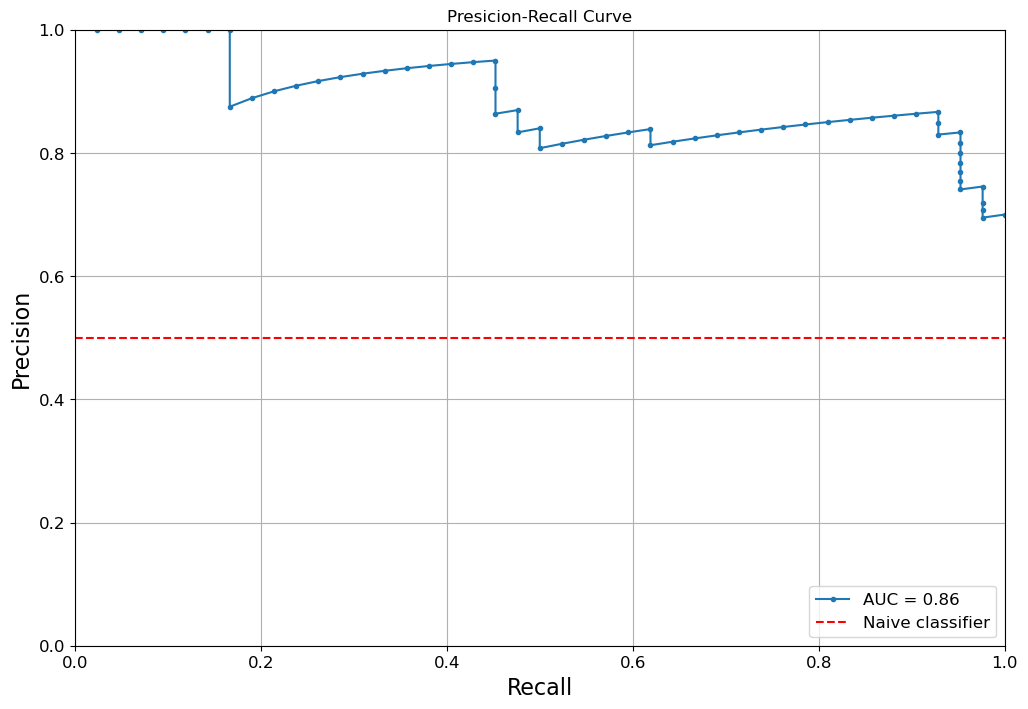

In [261]:
X_test_aug = np.hstack((np.ones((len(X_test),1)), X_test))

y_log = predict_log(X_test_aug, d['beta'])
auc, pres, recall, th = pr_curve(y_test_binary, y_log)

plt.figure(figsize=(12,8))
plt.title(f'Presicion-Recall Curve')
plt.plot(recall, pres, '.-', label=f'AUC = {auc:0.2f}')
plt.axhline(y=0.5, linestyle='--', color='red', label='Naive classifier')
plt.legend(loc='lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.grid()
plt.show()

**Analysis**: Using the Precision-Recall curve and the area under this curve (AUC-PR), we conclude that our model significantly outperforms the naive classifier (choosing class 0 or 1 with probability $\frac{1}{2}$) with an AUC of $0.86$ compared to $0.5$ for the naive classifier. The AUC being close to $1$ underlines a good efficacy.

## <a name="task-222"></a>

### (2.2.2) [(index)](#index-task-222)

In the following, we implement a kernelised version of the previous penalised logistic regression model using the Laplacian kernel:
$$k(x,y) = exp(-\alpha||x-y||_1),\quad\alpha>0$$

In [262]:
def kernel_matrix(X1, X2, alpha):
    """
    Construct kernel matrix K.
    Args:
        X1 (np.ndarray): Size (n1, m1).
        X2 (np.ndarray): Size (n2, m2).
        alpha (float): Kernel’s parameter.
    Return:
        kernel (np.ndarray): Kernel matrix (n1, n2).
    """
    
    n1,m1 = X1.shape
    n2,m2 = X2.shape
    kernel = np.zeros((n1,n2))

    for i in range(n1):
        exponent = -alpha * np.linalg.norm(X2 - X1[i], axis=1, ord=1)
        kernel[i,:] = np.exp(exponent)

    return kernel

In [263]:
def predict_kernel_log(K, u, intercept):
    y_log = logistic(K @ u + intercept)
    return y_log.squeeze()

The kernel version of the logistic regression model can be implemented by defining a new loss function:

$$L(\mathbf{u},b) = -\frac{1}{N}\sum_{i=1}^N y^{(i)} \log h_{\boldsymbol u,b}^k(\boldsymbol K^{(i)}) + (1-y^{(i)}) \log (1-h_{\boldsymbol u,b}^k(\boldsymbol K^{(i)})) + \frac{\lambda}{2}\boldsymbol u^T\boldsymbol K\boldsymbol u  ,$$

and its gradients:

$$
\nabla_{u} L(\mathbf{u},b) = \frac{1}{N}\sum_{i=1}^N (h_{\boldsymbol u,b}^k(\boldsymbol K^{(i)}) - y^{(i)})\boldsymbol K^{(i)} + \lambda \boldsymbol K\boldsymbol u
$$

$$
\frac{\partial L(\mathbf{u},b)}{\partial b} = \frac{1}{N}\sum_{i=1}^N (h_{\boldsymbol u,b}^k(\boldsymbol K^{(i)}) - y^{(i)})\boldsymbol K^{(i)}
$$


where $\mathbf{K}$ is the matrix containing the kernel functions, i.e.
 $\mathbf{K}_{ij} = k(\mathbf{x}^{(i)},\mathbf{x}^{(i)})$ and:
 
$$
h_{\boldsymbol u,b}^k(\boldsymbol K^{(i)}) = \frac{1}{1+e^{-(\boldsymbol K^{(i)}\boldsymbol u + b)}}.
$$

To perform the optimisation, we simply modify the functions introduced above.

In [264]:
def propagate_kernel(K, u, y, intercept, penalty):
    """
    Args:
        K (np.ndarray): Kernel matrix (n1, n2).
        u (np.ndarray): Parameter vector of size (n2, 1).
        y (np.ndarray): True label vector of size N.
        intercept (float).
        penalty (float).
    Returns:
        loss: Loss value.
        dbeta: Gradient of the loss with respect to beta.
        dintercept: Derivative of the loss with respect to the intercept.
    """
    
    y_kernel_log = predict_kernel_log(K, u, intercept)

    # Mean sample loss function
    loss = - np.mean(y * np.log(y_kernel_log) + (1 - y) * np.log(1 - y_kernel_log)) + 0.5 * penalty * np.dot(u,K@u)

    # Derivatives
    du = (np.mean(K.T * (y_kernel_log - y), axis=1) + penalty * (K@u)).reshape(-1, 1)
    dintercept = - np.mean(y * (1 - y_kernel_log) - (1 - y) * y_kernel_log)
    
    loss = np.squeeze(loss)
    du = np.squeeze(du)
    
    # Store gradients in a dictionary
    grads = {'du': du, 'dintercept': dintercept}
  
    return grads, loss

In [265]:
def kernel_optimise(K, u, y, intercept, penalty, num_iterations=2000, learning_rate=0.1, print_loss=False):
    """
    Args:
        K (np.ndarray): Kernel matrix (n1, n2).
        u (np.ndarray): Parameter vector of size (n2, 1).
        y (np.ndarray): vector of training targets/observations (n1, 1).
        intercept (float).
        penalty (float).
        num_iterations: Number of iterations.
        learning_rate: Step size in updating procedure.
        print_loss: 'True' to print the mean loss every 100 iterations.
    Returns:
        params: Dictionary containing the parameter vector beta.
        grads: Dictionary containing the gradient.
        loss_history: List of all the loss values computed during the optimisation.
    """
    
    loss_history = []
    
    for i in range(num_iterations):

        # Calculating the loss and gradients
        grads, loss = propagate_kernel(K, u, y, intercept, penalty)
      
        # Retrieving derivatives from grads
        du = grads['du']
        dintercept = grads['dintercept']
        
        # Updating procedure
        u = u - learning_rate * du
        intercept = intercept - learning_rate * dintercept
        
        # Record the loss values
        if i % 100 == 0:
            loss_history.append(loss)
      
        # Printing the loss every 100 iterations
        if print_loss and i % 100 == 0:
            print ('Loss after iteration %i: %f' %(i, loss))
  
    # Saving parameters and gradients in dictionary
    params = {'u': u, 'intercept': intercept}
    grads = {'du': du, 'dintercept': dintercept}
  
    return params, grads, loss_history

In [266]:
def predict_kernel(K, u, intercept):
    """
    Args:
        K (np.ndarray): Kernel matrix.
        u (np.ndarray): Parameter vector.
        intercept (float).
    Return:
        y_pred: Vector containing all binary predictions (0/1).
    """

    # Predicting the probabilities
    y_log = predict_kernel_log(K, u, intercept)
    
    y_pred = y_log.round().reshape(1, -1)
    
    return y_pred

In [267]:
def kernel_model(X_train, y_train, X_test, y_test, alpha, penalty, num_iterations=2000, learning_rate=0.1, print_loss=False):
    """
    Args:
        X_train (np.ndarray): Matrix of training inputs (N, p).
        y_train (np.ndarray): Vector of training targets/observations (N, 1).
        X_test (np.ndarray): Matrix of testing inputs (N_test, p).
        y_test (np.ndarray): Vector of testing targets/observations (N_test, 1).
        alpha (float): Kernel's parameter.
        penalty (float).
        num_iterations: Number of iterations.
        learning_rate: Step size in updating procedure.
        print_loss: 'True' to print the mean loss every 100 iterations.
    Returns:
        d_kernel: Kernalised logistic regression model.
    """
    
    # Kernel matrices
    K_train = kernel_matrix(X_train, X_train, alpha)
    K_test = kernel_matrix(X_test, X_train, alpha)
    
    # Initialising parameters with zeros
    u = np.zeros(K_train.shape[1])
    intercept = 0.
    
    # Gradient descent
    parameters, grads, loss_history = kernel_optimise(K_train, u, y_train, intercept, penalty, num_iterations=1000, learning_rate=0.1, print_loss=False)

    # Retrieving parameter vector beta from dictionary 'parameters'
    u = parameters['u']
    intercept = parameters['intercept']
    
    # Predicting test and training set examples
    y_pred_train = predict_kernel(K_train, u, intercept)
    y_pred_test = predict_kernel(K_test, u, intercept)

    # Printing train/test accuracy
    print(f'For alpha = {alpha}:')
    print('Training accuracy: {} %'.format(100 - np.mean(np.abs(y_pred_train - y_train)) * 100))
    print('Test accuracy: {} % \n'.format(100 - np.mean(np.abs(y_pred_test - y_test)) * 100))

    # Saving all the information
    d_kernel = {'mean_loss_history': loss_history, 'y_pred_test': y_pred_test, 'y_pred_train': y_pred_train, 'u': u, 'intercept': intercept, 'learning_rate': learning_rate, 'num_iterations': num_iterations}
  
    return d_kernel

<a name="task-223"></a>

### (2.2.3) [(index)](#index-task-223)

We train our kernelised version of the penalised logistic regression model for $\alpha=100$ and $\alpha=0.3$.

In [268]:
d_kernel_100 = kernel_model(X_train.to_numpy(), y_train_binary.to_numpy(), X_test.to_numpy(), y_test_binary.to_numpy(), alpha=100, penalty=0.0025, num_iterations=2000, learning_rate=0.1, print_loss=False)
d_kernel_03 = kernel_model(X_train.to_numpy(), y_train_binary.to_numpy(), X_test.to_numpy(), y_test_binary.to_numpy(), alpha=0.3, penalty=0.0025, num_iterations=2000, learning_rate=0.1, print_loss=False)

For alpha = 100:
Training accuracy: 68.9655172413793 %
Test accuracy: 70.0 % 

For alpha = 0.3:
Training accuracy: 86.20689655172414 %
Test accuracy: 85.0 % 



- For $\alpha=100$: The accuracies on the train set $69$% and test set $70$% are better than the mean accuracy of a naive classifier (choosing class 0 or 1 with probability $\frac{1}{2}$), however, they are inferior to those of the penalised logistic regression model.

- For $\alpha=0.3$: The model shows even higher accuracy on both train set $86$% and test set $85$%, it even outperforms the penalised logistic regression model.

As seen above, the choice of $\alpha$ is important for the accuracy of our model. 

We evaluate its performance on the test set via the Precision-Recall curve and the area under this curve (AUC-PR).

In [269]:
def plot_roc(X_train, X_test, y_test, d_kernel, alpha):
    """
    Args:
        X_train (np.ndarray): Matrix of training inputs (N, p).
        X_test (np.ndarray): Matrix of testing inputs (N_test, p).
        y_test (np.ndarray): Vector of testing targets/observations (N_test, 1).
        d_kernel: Kernelised logistic regression model.
        alpha (float): Kernel's parameter.
    """
    
    K_test = kernel_matrix(X_test.to_numpy(), X_train.to_numpy(), alpha=alpha)

    y_log = predict_kernel_log(K_test, d_kernel['u'], d_kernel['intercept'])
    auc, pres, recall, th = pr_curve(y_test, y_log)

    plt.figure(figsize=(12,8))
    plt.title(f'Precision-Recall curve with alpha={alpha}')
    plt.plot(recall, pres, '.-', label=f'AUC = {auc:0.2f}')
    plt.axhline(y=0.5, linestyle='--', color='red', label='Naive classifier')
    plt.legend(loc='lower right')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    plt.grid()
    plt.show()

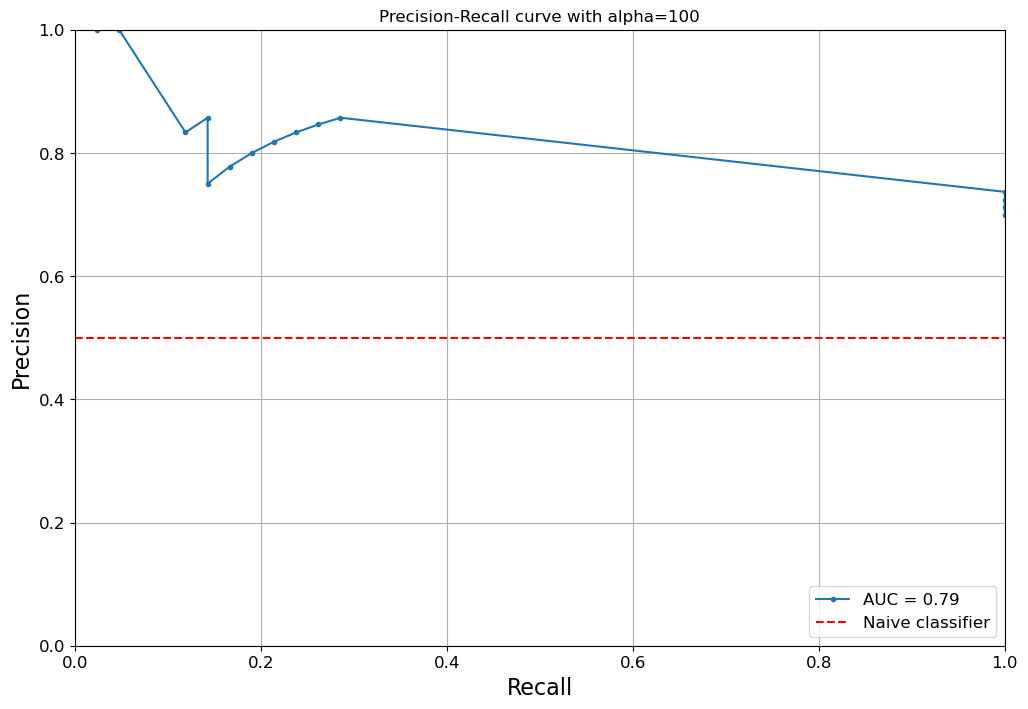

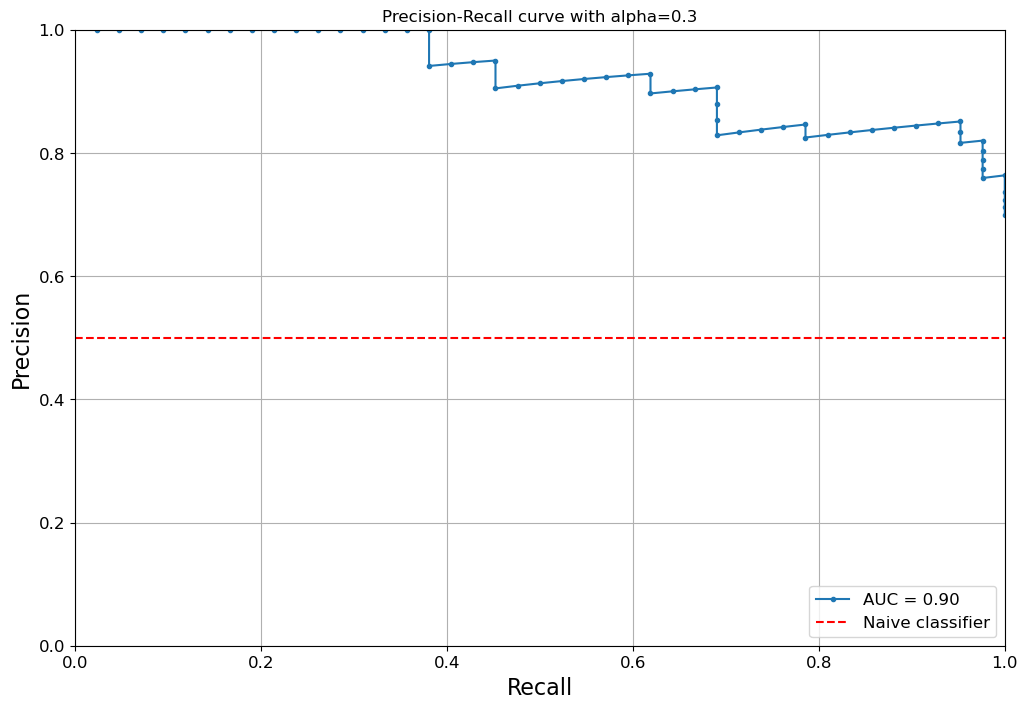

In [270]:
plot_roc(X_train, X_test, y_test_binary, d_kernel_100, alpha=100)
plot_roc(X_train, X_test, y_test_binary, d_kernel_03, alpha=0.3)

**Analysis:** 
- For $\alpha=100$, despite not surpassing the penalised logistic regression model with an AUC of $0.79$ compared to $0.86$, the model is still doing better than the naive classifier presenting reasonnable performance. 

- For $\alpha=0.3$, as seen before, the model shows significant improvement compared to $\alpha=100$, with an AUC of $0.90$. Its AUC being close to $1$ suggests that the model is highly efficient.

Finally, the kernelised version with $\alpha=0.3$ outperforms the penalised logistic regression model (**2.2.1**). In conclusion, among our three different models, it is the kernelised version with $\alpha=0.3$ that performs the best. Additionally, as underlined before, the choice of the kernel's parameter $\alpha$ has a significant impact on the accuracy of our kernelised version. Hence, choosing the optimal $\alpha$ (e.g. by cross-validation) may lead to an even more accurate model.